# Data Statistics and Evaluation

In the following demo, we will:
* Calculate total number of hours recorded for each site and locate files which could not be read with TuneR's readwave function.
* Calculate Summary Statistcs for each Bioacoustic Index
* Visualization of Indices
* Cluster Analysis (for indices)
* Correlation Analysis (for indices)
* Cluster Analysis following Correlation Analysis. 

First we install the necessary packages:

In [99]:
library(tuneR)
library(tidyr)
library(ggplot2)
library(factoextra)
library(cluster)
library(plyr)
library(repr)
options(repr.plot.width=15, repr.plot.height=8)

## Basic Sound Data Statistics and Data 

The following code gives the hours recorded at each site (along with the total. Uncommenting the the expressions in the warning/error brackets also gives the files which could not be processed using TuneR's readWave function along with why the function fails (8 failed files). Errors include:
* bin-reading error(2 files): ``` <simpleError in readBin(con, int, n = 4, size = 1, endian = "little", signed = FALSE) %*% 2^c(0, 8, 16, 24): non-conformable arguments> ```
* char-reading error(3 files): ``` <simpleError in readChar(con, 4): invalid UTF-8 input in readChar()> ```
* non-valid WAVE file(3 files): ``` <simpleError in readWave(soundfile, header = TRUE): This seems not to be a valid RIFF file of type WAVE.> ```


As shown below there is about 1,260 hours of usable recorded sound.

In [100]:
DATA_LIBRARY_PATH<- "/media/colton/My Passport/data_library"
file.paths <- list.files(DATA_LIBRARY_PATH)
total <- 0
nonproblem_files <- 0
total_files <- 0
for (i in 1:length(file.paths)){
  duration <- 0
  sitepath <- paste(DATA_LIBRARY_PATH,file.paths[i],sep='/')
  sitefiles <- list.files(sitepath,recursive=TRUE, pattern = "wav$")
  for (j in 1:length(sitefiles)){
    soundfile <- paste(sitepath,sitefiles[j],sep='/')
    total_files <- total_files + 1
    result <- tryCatch(expr={
    hdr <- readWave(soundfile,header=TRUE)
    sr <- hdr$sample.rate
    samples<-hdr$samples
    duration <- duration + samples/(sr*3600)
    nonproblem_files <- nonproblem_files + 1
    }, warning = function(w) {
      #print(w)
      #print(soundfile)
    }, error = function(e) {
      #print(e)
      #print(soundfile)
    })
}
  total <- duration + total
  print(paste(paste(file.paths[i],duration,sep=": "),"hours"))
}
print(paste("Total",total,sep=": "))
print(paste("Non-Problem Files",nonproblem_files,sep=": "))
print(paste("Total Files",total_files,sep=": "))

[1] "Audubon_Society: 29.3517748148148 hours"
[1] "Biosphere_2: 27.2658311111111 hours"
[1] "Chuparosa_Inn: 21.59808 hours"
[1] "Desert_museum: 39.1802755555556 hours"
[1] "Empire_Ranch: 24.7657748148148 hours"
[1] "Gates Pass: 123.29344 hours"
[1] "Jake: 91.3273303703704 hours"
[1] "Nirav: 95.5661096296297 hours"
[1] "Patagonia_lake: 25.5610548148148 hours"
[1] "Paton_Hummingbird: 24.87544 hours"
[1] "Proctor_road: 24.993522962963 hours"
[1] "Ruth: 111.326684444445 hours"
[1] "Sabino_canyon: 50.0686074074074 hours"
[1] "Saguaro_NP: 136.065831111111 hours"
[1] "Silvestrer_Spring: 24.6300503703704 hours"
[1] "Sweetwater: 140.433386666667 hours"
[1] "Theresa: 105.168971851852 hours"
[1] "Tumamoc: 163.181576296296 hours"
[1] "Total: 1258.65374222222"
[1] "Non-Problem Files: 1301"
[1] "Total Files: 1309"


## Index Stats and Clustering Analysis
The calculated indices are read in from a CSV(comma separated values) file.  The first six rows of the dataframe are shown below.

In [101]:
INDEX_CSV <- "/media/colton/My Passport/final.csv"
index_data <- read.csv(INDEX_CSV,header=TRUE)
head(index_data)

,Site,Date....as.Date.character....format.....Y..m..d..,Time....character..,bioacoustic....double..,amplitude....double..,temporal_entropy....double..,spectral_entropy....double..,acoustic_entropy....double..,acoustic_diversity....double..,acoustic_evenness....double..,acoustic_complexity....double..,nrows....double..,ndsi....double..
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,Audubon_Society,2019-04-18,11:12:36,101.0132,0.09830943,0.9724801,0.8142960,0.7918867,1.811299,0.514931,196.6844,1,0.4799106
2,Audubon_Society,2019-04-18,11:17:36,113.4433,0.11335600,0.9730184,0.8080708,0.7862678,1.767159,0.539738,201.1060,0,0.8579672
3,Audubon_Society,2019-04-18,11:22:36,125.1966,0.20363086,0.9820155,0.7945508,0.7802612,1.744127,0.557559,196.8785,0,0.5911719
4,Audubon_Society,2019-04-18,11:27:36,147.6329,0.16143239,0.9848378,0.7754547,0.7636971,1.768792,0.530202,211.8268,0,0.8497890
5,Audubon_Society,2019-04-18,11:32:36,120.6462,0.18025170,0.9826372,0.7972910,0.7834478,1.733753,0.558135,199.5438,1,0.5483259
6,Audubon_Society,2019-04-18,11:37:36,150.6320,0.09876261,0.9809657,0.7997804,0.7845571,1.580442,0.617017,191.5337,0,0.7192530


A generic histogram is plotted for each of the alpha indices.

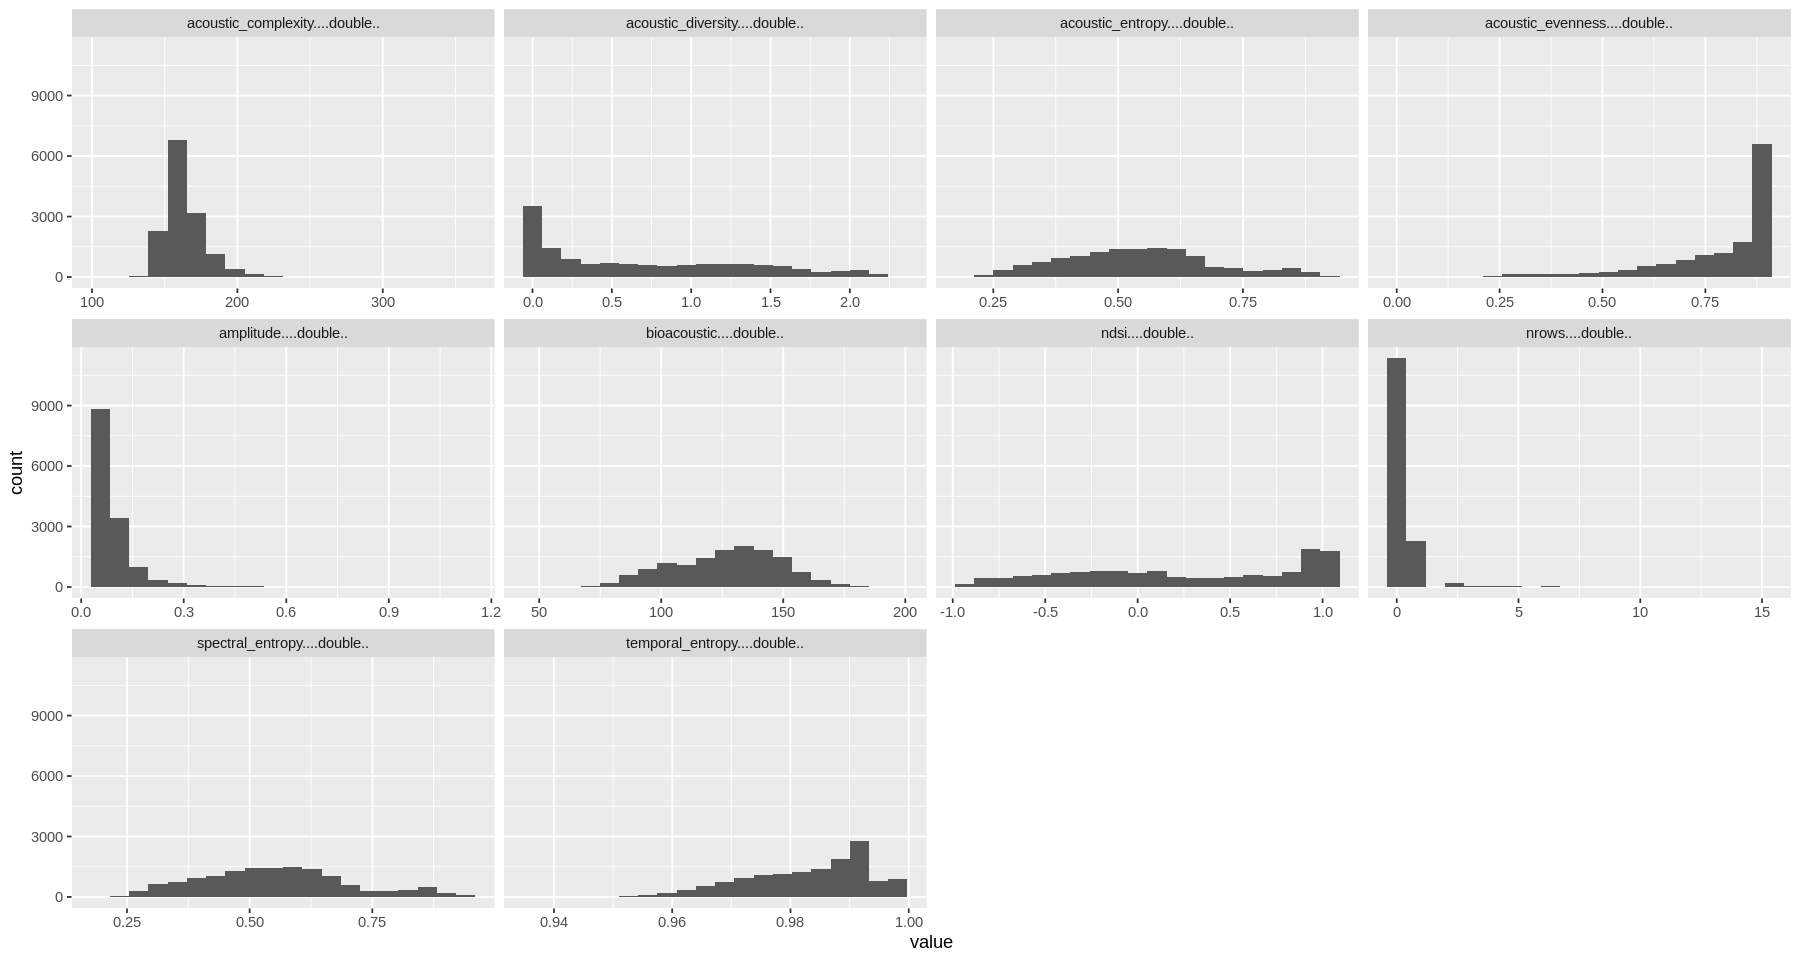

In [102]:
ggplot(gather(index_data[,4:13]), aes(value)) + 
    geom_histogram(bins = 20) + 
    facet_wrap(~key, scales = 'free_x')

Basic Summarization Statistics are given for each of the alpha indices.

In [103]:
summary(index_data)
#colnames(index_data)

            Site      Date....as.Date.character....format.....Y..m..d..
 Tumamoc_NA   :1827   2019-04-14:  542                                 
 Sweetwater_NA:1571   2018-09-07:  528                                 
 Saguaro_NP   :1522   2018-09-08:  528                                 
 Gates_Pass   :1379   2019-06-09:  528                                 
 Ruth_NA      :1231   2019-06-10:  528                                 
 Theresa_NA   :1197   2019-06-11:  528                                 
 (Other)      :5366   (Other)   :10911                                 
 Time....character.. bioacoustic....double.. amplitude....double..
 15:0:0 :   54       Min.   : 48.39          Min.   :0.03201      
 15:10:0:   53       1st Qu.:110.06          1st Qu.:0.04953      
 15:15:0:   53       Median :128.44          Median :0.06864      
 15:5:0 :   53       Mean   :126.22          Mean   :0.09350      
 2:0:0  :   53       3rd Qu.:142.35          3rd Qu.:0.10508      
 2:10:0 :   53       M

In [104]:
#row.names(index_data) <- paste(index_data$Site, "-", index_data$Date....as.Date.character....format.....Y..m..d..,"-",index_data$Time....character..)
index_data[,4:13] <- scale(index_data[,4:13])
head(index_data)


,Site,Date....as.Date.character....format.....Y..m..d..,Time....character..,bioacoustic....double..,amplitude....double..,temporal_entropy....double..,spectral_entropy....double..,acoustic_entropy....double..,acoustic_diversity....double..,acoustic_evenness....double..,acoustic_complexity....double..,nrows....double..,ndsi....double..
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Audubon_Society,2019-04-18,11:12:36,-1.15128774,0.05357391,-1.02517852,1.720303,1.657195,1.725522,-1.812454,2.431469,0.7502799,0.3758906
2,Audubon_Society,2019-04-18,11:17:36,-0.58359367,0.22106740,-0.97234193,1.679443,1.619785,1.657601,-1.647048,2.757101,-0.3177701,0.9984916
3,Audubon_Society,2019-04-18,11:22:36,-0.04681131,1.22597713,-0.08918344,1.590702,1.579793,1.622160,-1.528223,2.445764,-0.3177701,0.5591209
4,Audubon_Society,2019-04-18,11:27:36,0.97787851,0.75623775,0.18785748,1.465362,1.469510,1.660114,-1.710632,3.546632,-0.3177701,0.9850234
5,Audubon_Society,2019-04-18,11:32:36,-0.25463050,0.96572811,-0.02815722,1.608688,1.601009,1.606197,-1.524382,2.642051,0.7502799,0.4885602
6,Audubon_Society,2019-04-18,11:37:36,1.11485166,0.05861859,-0.19222905,1.625027,1.608395,1.370288,-1.131774,2.052151,-0.3177701,0.7700507


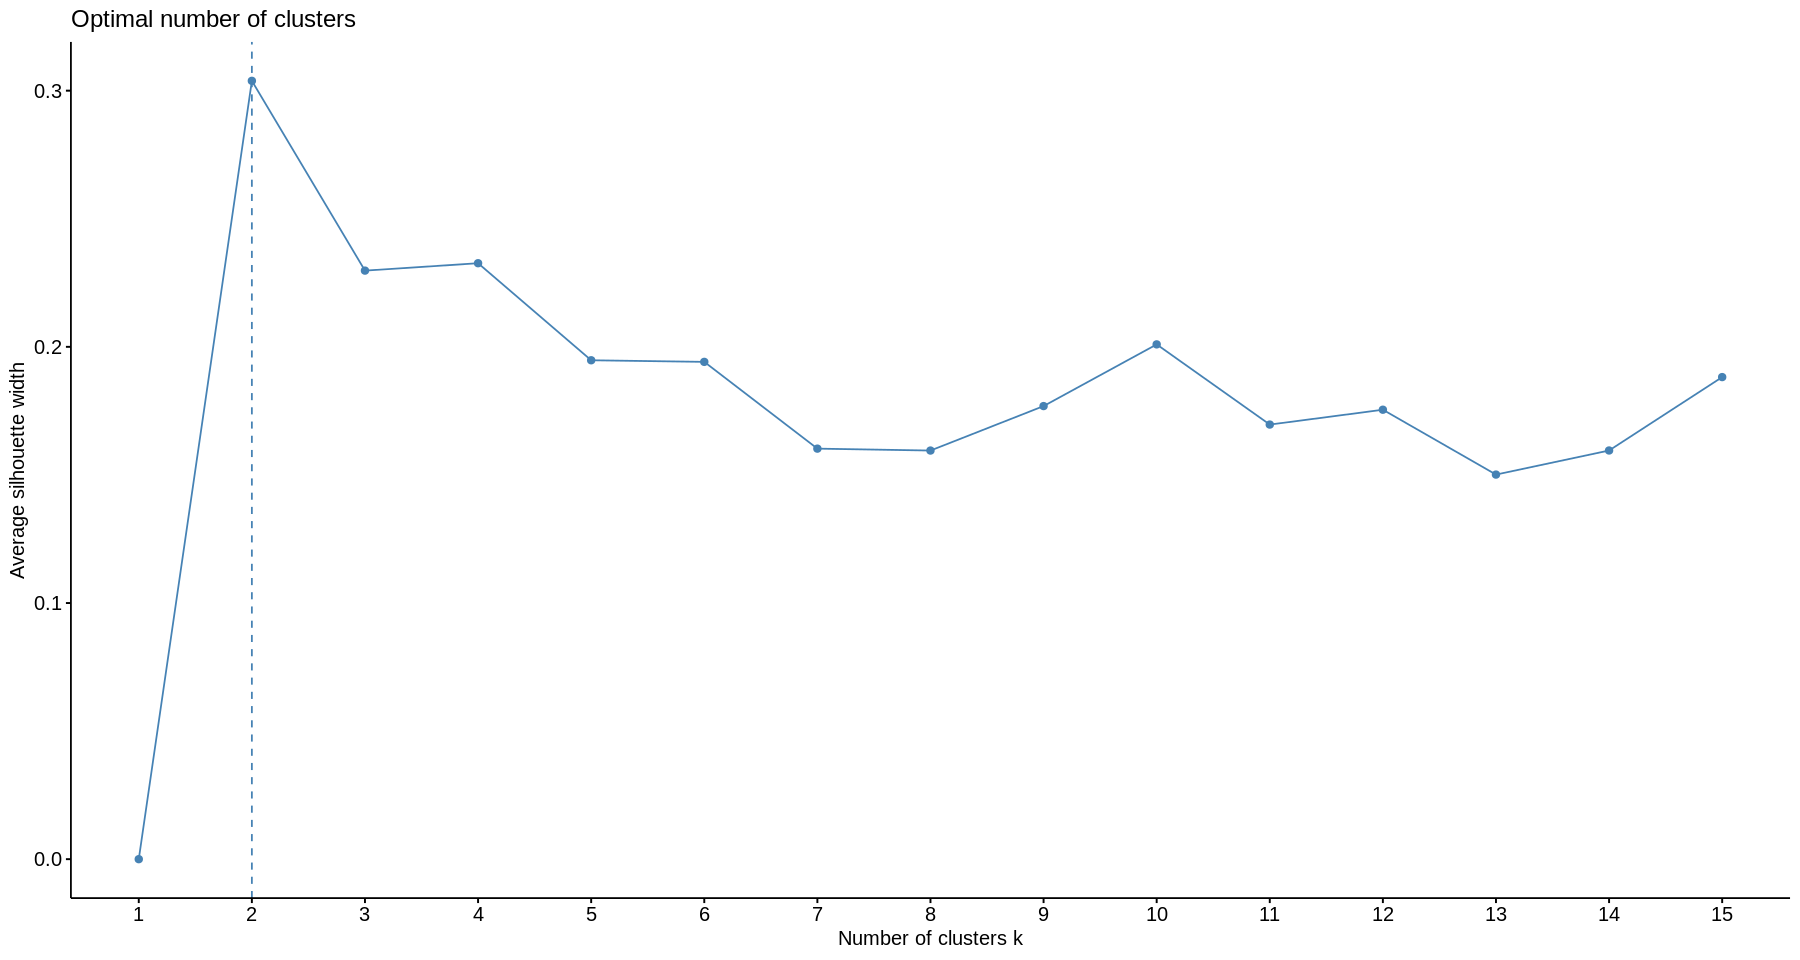

In [105]:
fviz_nbclust(index_data[,4:13],FUNcluster=clara,method = "silhouette",k.max=15,verbose=TRUE)

[1] 2037  202 2897  909 1436 1435 1423  253 1506 1995

,bioacoustic....double..,amplitude....double..,temporal_entropy....double..,spectral_entropy....double..,acoustic_entropy....double..,acoustic_diversity....double..,acoustic_evenness....double..,acoustic_complexity....double..,nrows....double..,ndsi....double..
1,0.83485683,-0.31028438,0.8086261,0.6469061,0.67891525,0.95258517,-0.6432579,-0.3968183,0.1258089,0.63288258
2,-1.28081818,0.62361070,-0.1501073,2.1967205,2.17875981,1.87037754,-2.5284662,-0.2545334,6.6562794,1.09977029
3,0.51194633,-0.14098015,0.4102119,0.0525521,0.06625893,-0.44752506,0.5071161,-0.3663408,-0.1706690,-0.98584092
4,1.01836652,-0.24913319,0.5221568,0.4493696,0.46736019,0.97388626,-0.7508920,1.6888583,-0.1144998,0.78142649
5,-0.04740342,-0.15231215,-0.1284879,0.1342781,0.12740214,0.08903523,0.1719995,-0.4816057,0.1627037,0.95287362
6,-1.20999416,-0.54394151,1.0070902,-1.0889533,-1.06089044,-0.72380977,0.6189120,-0.6321444,-0.2262229,-0.14712746
7,-1.05722631,0.10715722,-0.4847860,1.7368902,1.70445639,1.61838911,-1.8795838,0.4786258,0.1400729,1.11990510
8,-0.54598262,5.52901927,0.1832874,-1.2356002,-1.22834599,-0.65490385,0.5377866,1.6885521,-0.2966624,-0.40695586
9,-0.33198493,0.26743791,-1.3457500,-1.3113739,-1.34144381,-0.86627135,0.6780336,0.7382683,-0.3156425,-0.01755854
10,0.04825419,0.09330813,-0.9375246,-0.5696440,-0.59893213,-0.91672918,0.7102011,-0.1180730,-0.2808300,-0.99603585


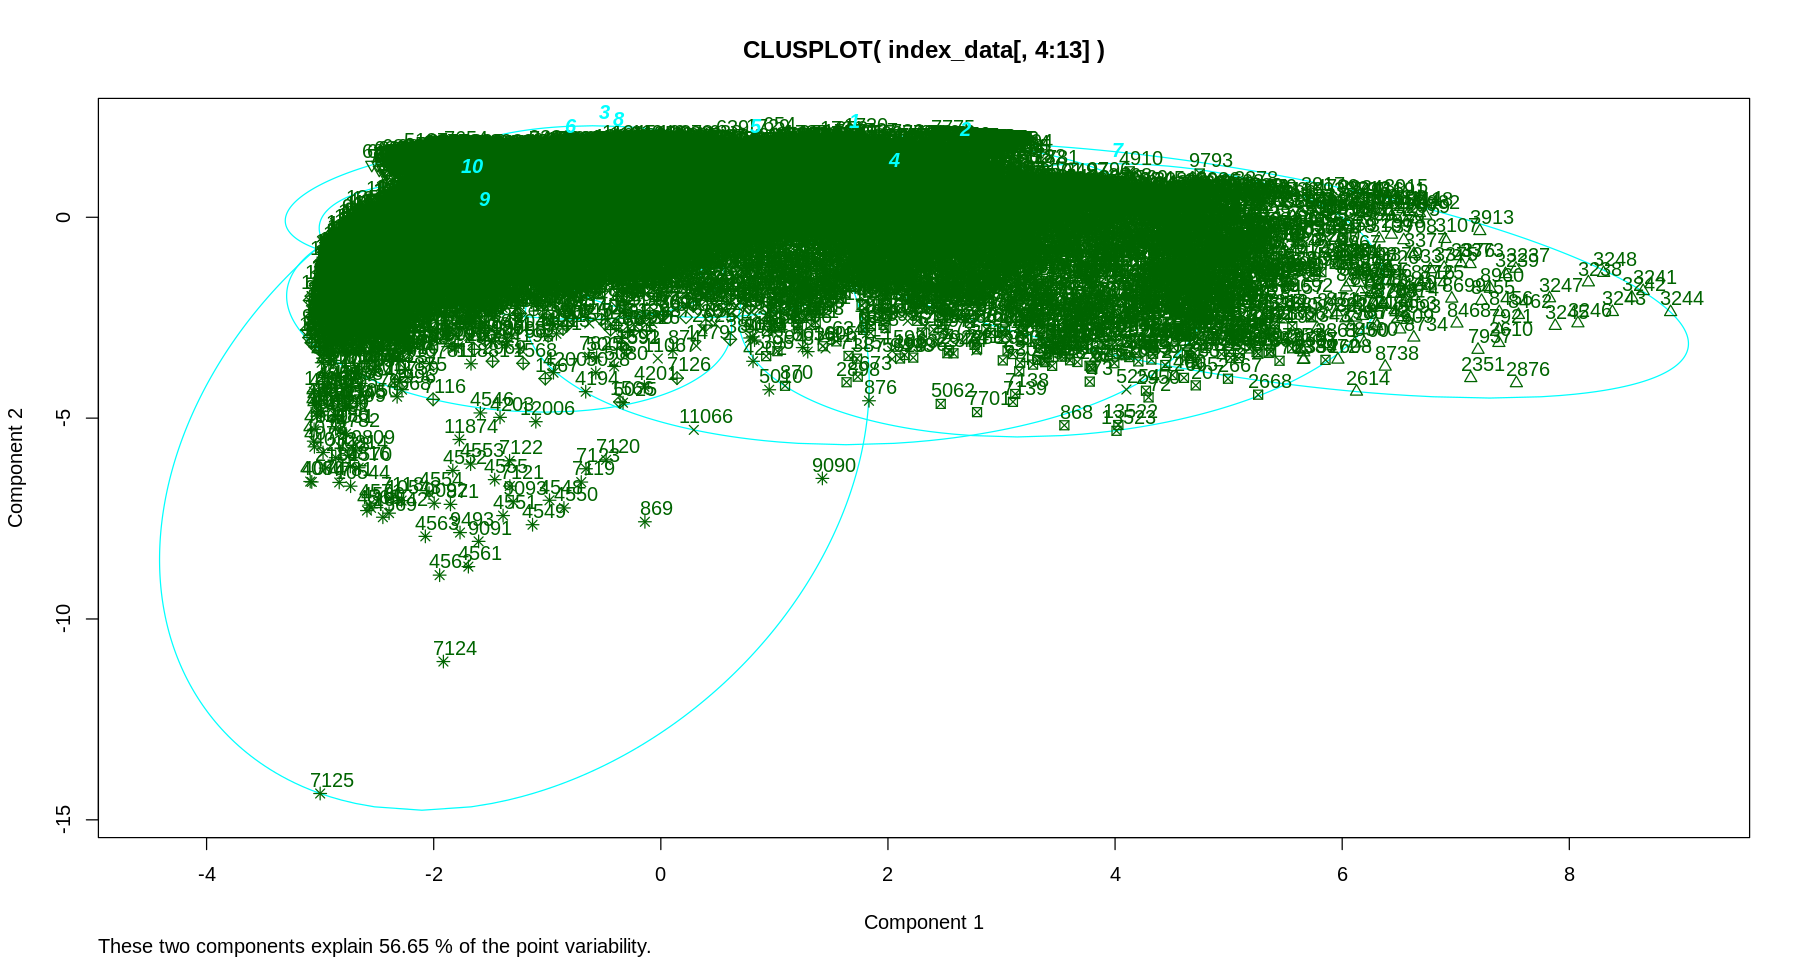

In [106]:
# K-Means Clustering with 5 clusters
NUM_CLUSTERS <- 10
fit <- kmeans(index_data[,4:13],NUM_CLUSTERS)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

index_data <- data.frame(index_data, fit$cluster) 

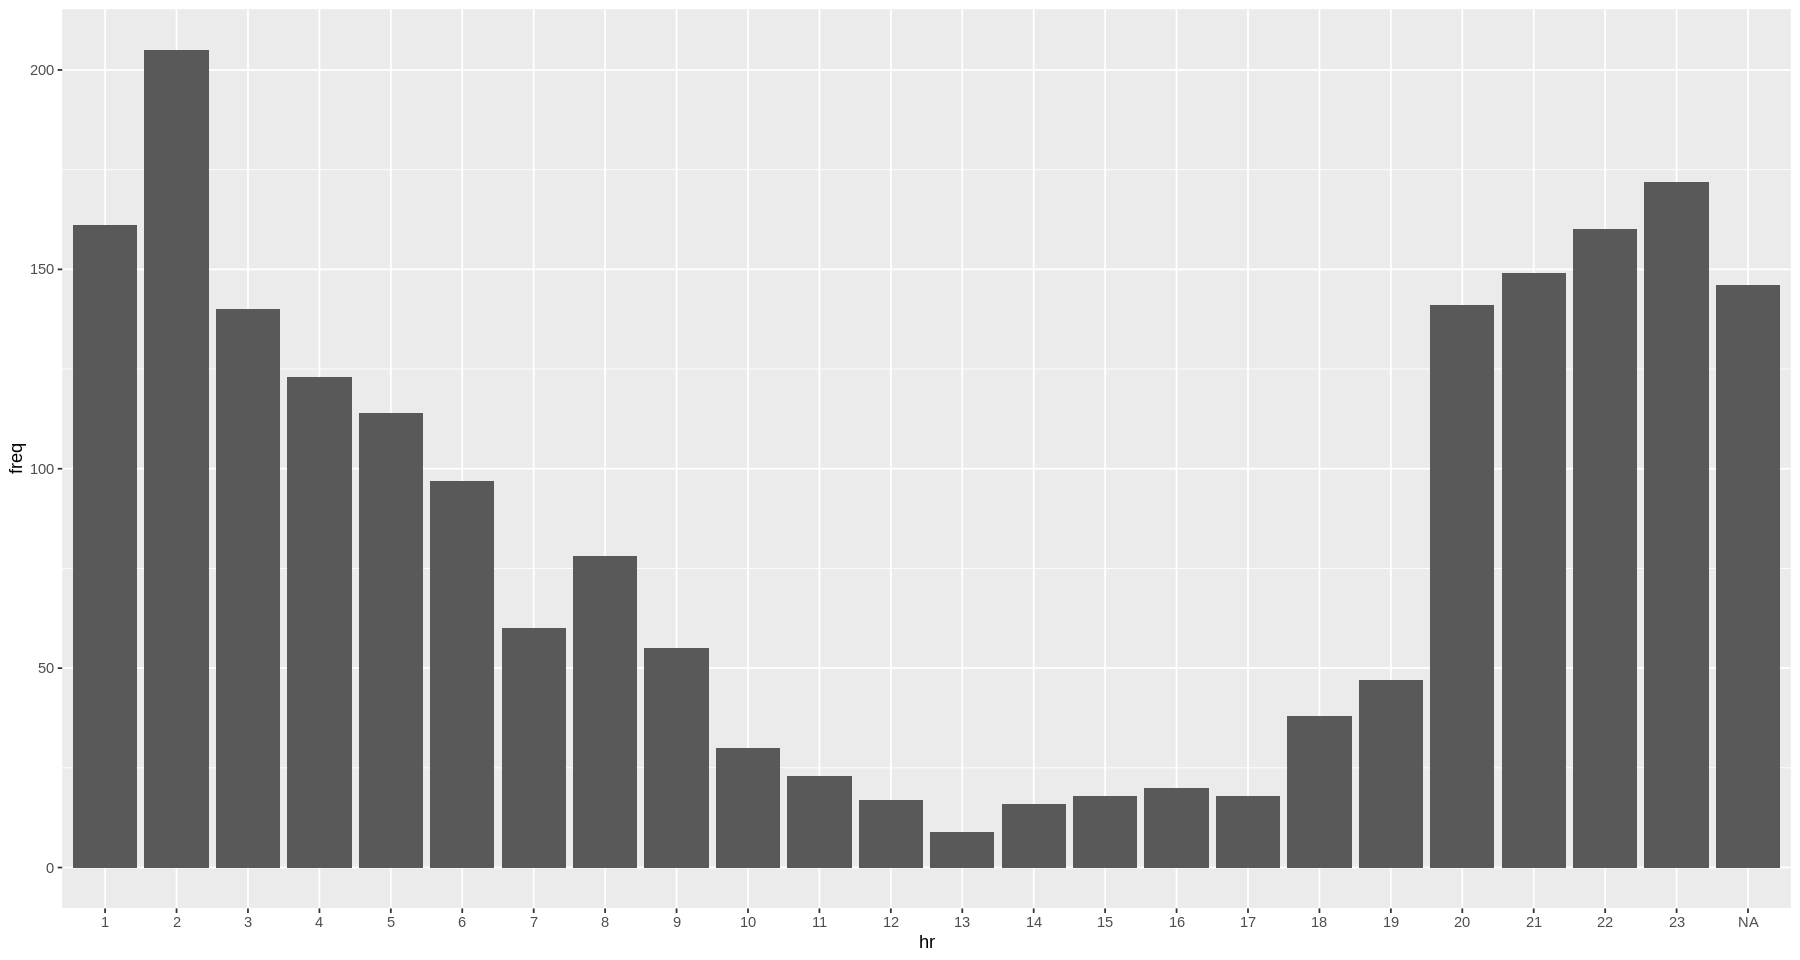

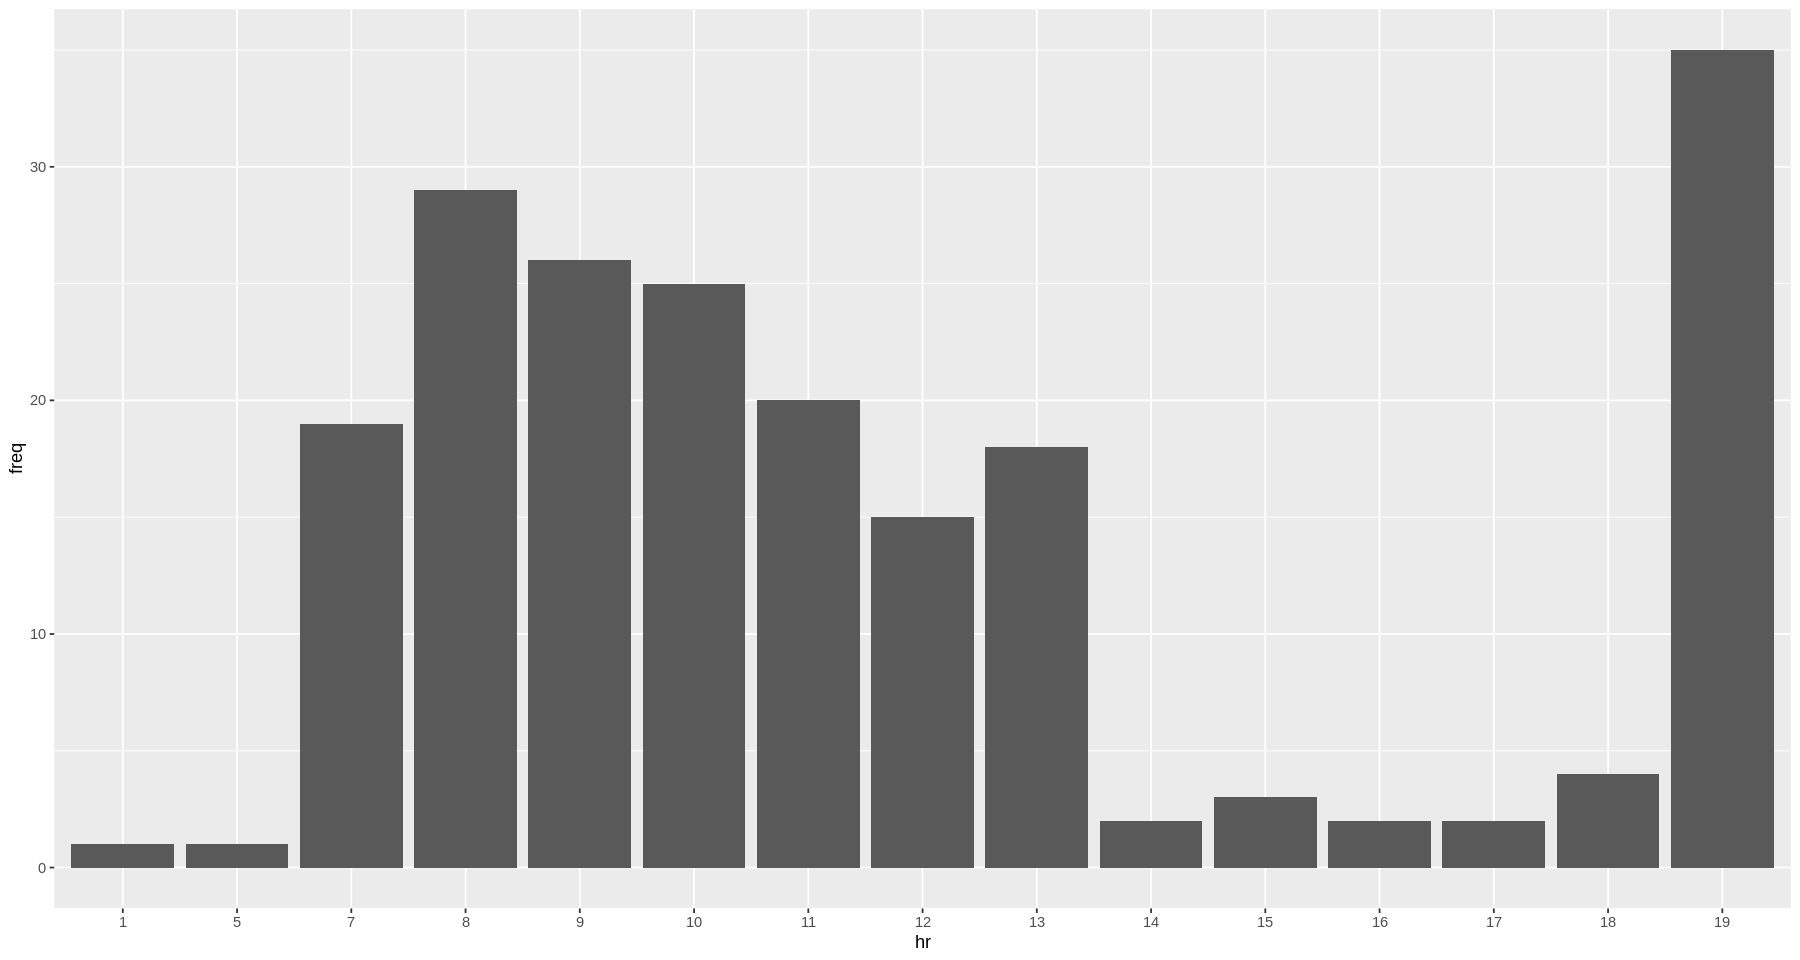

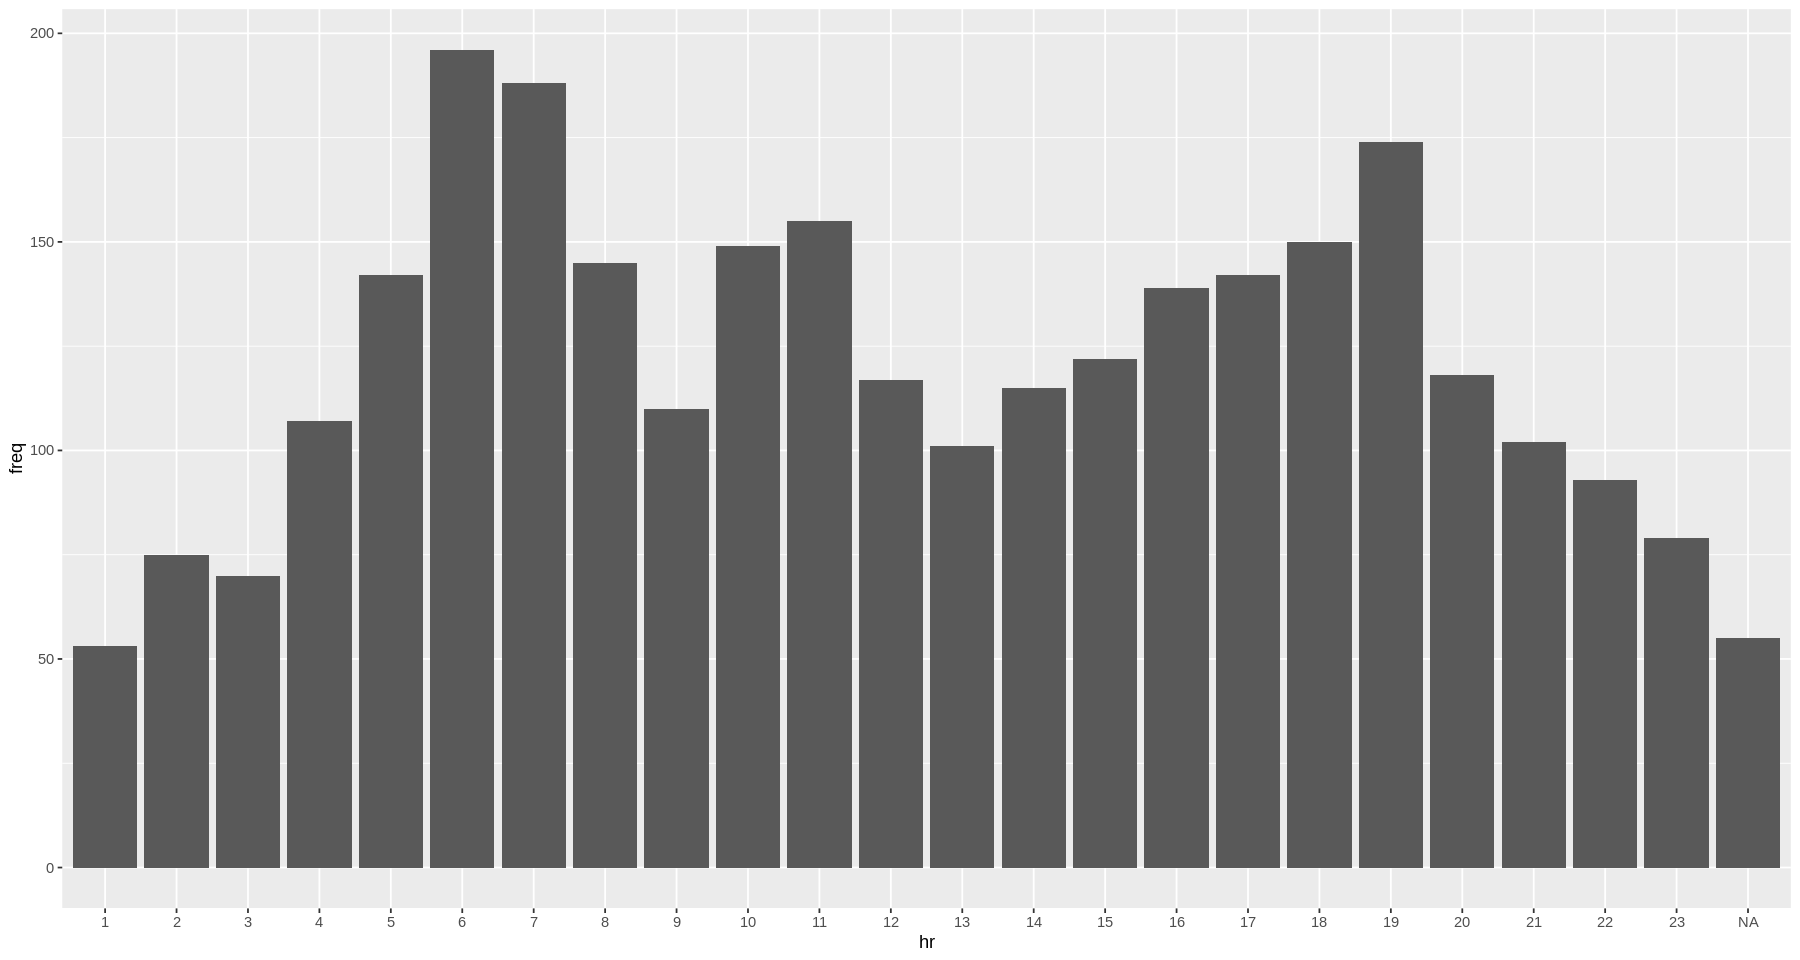

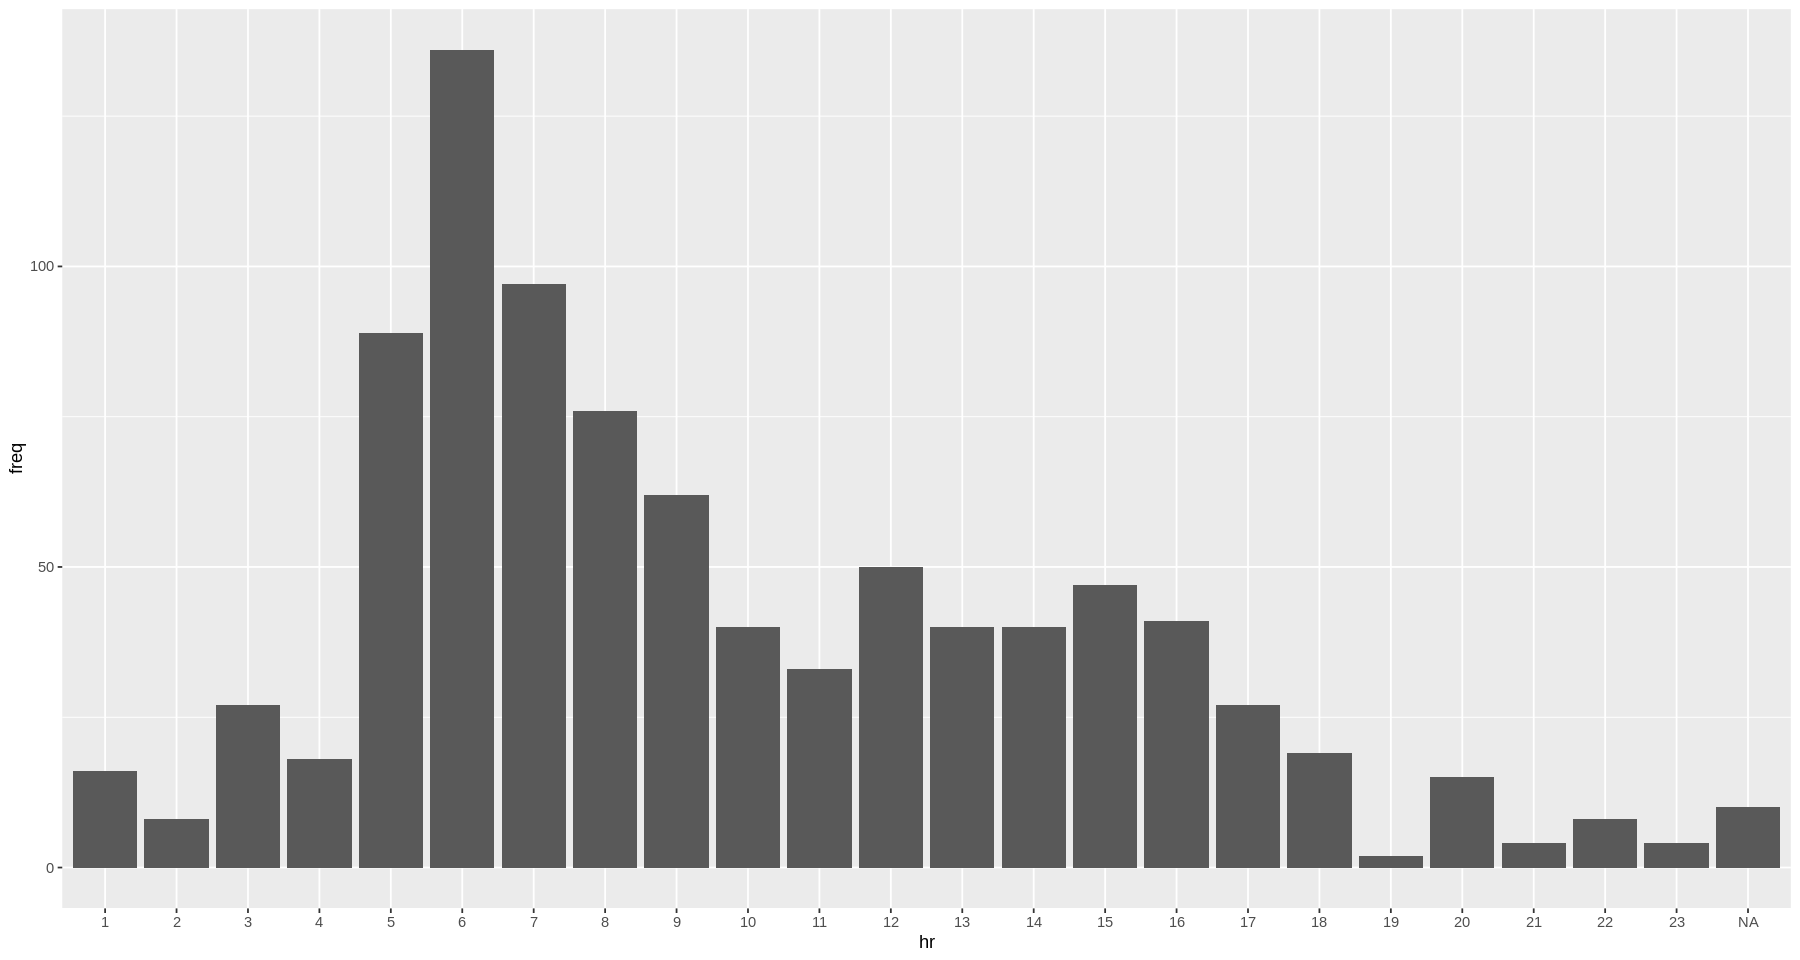

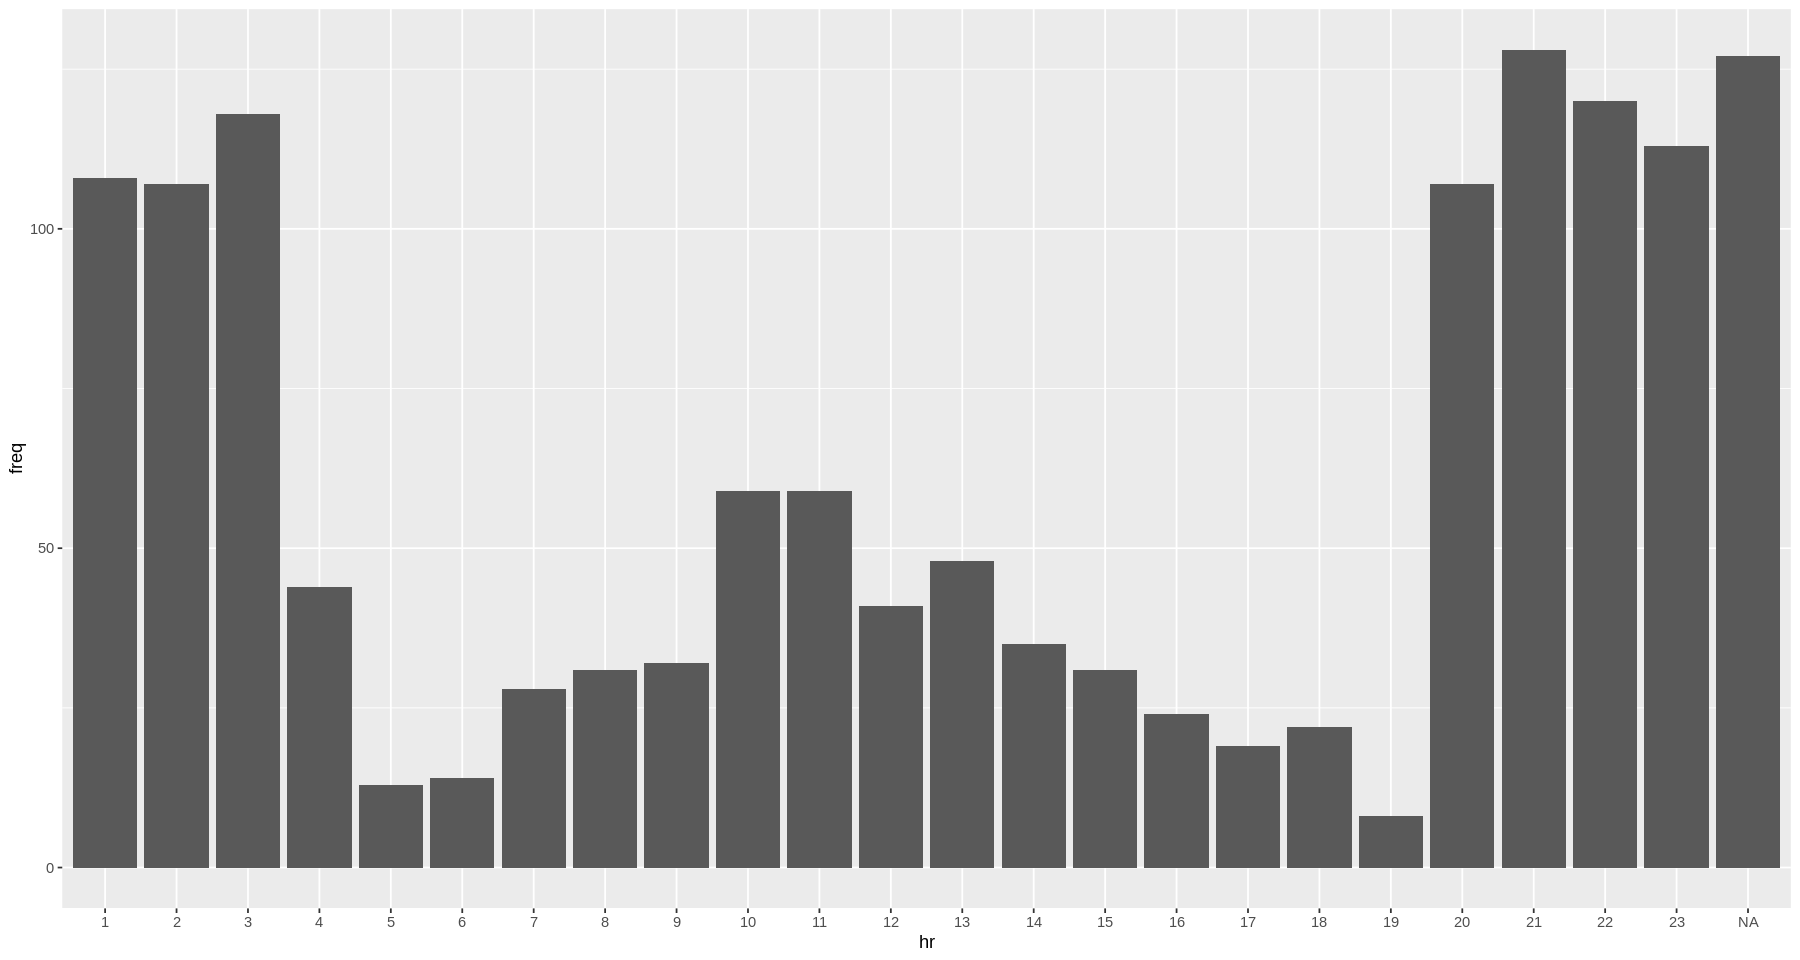

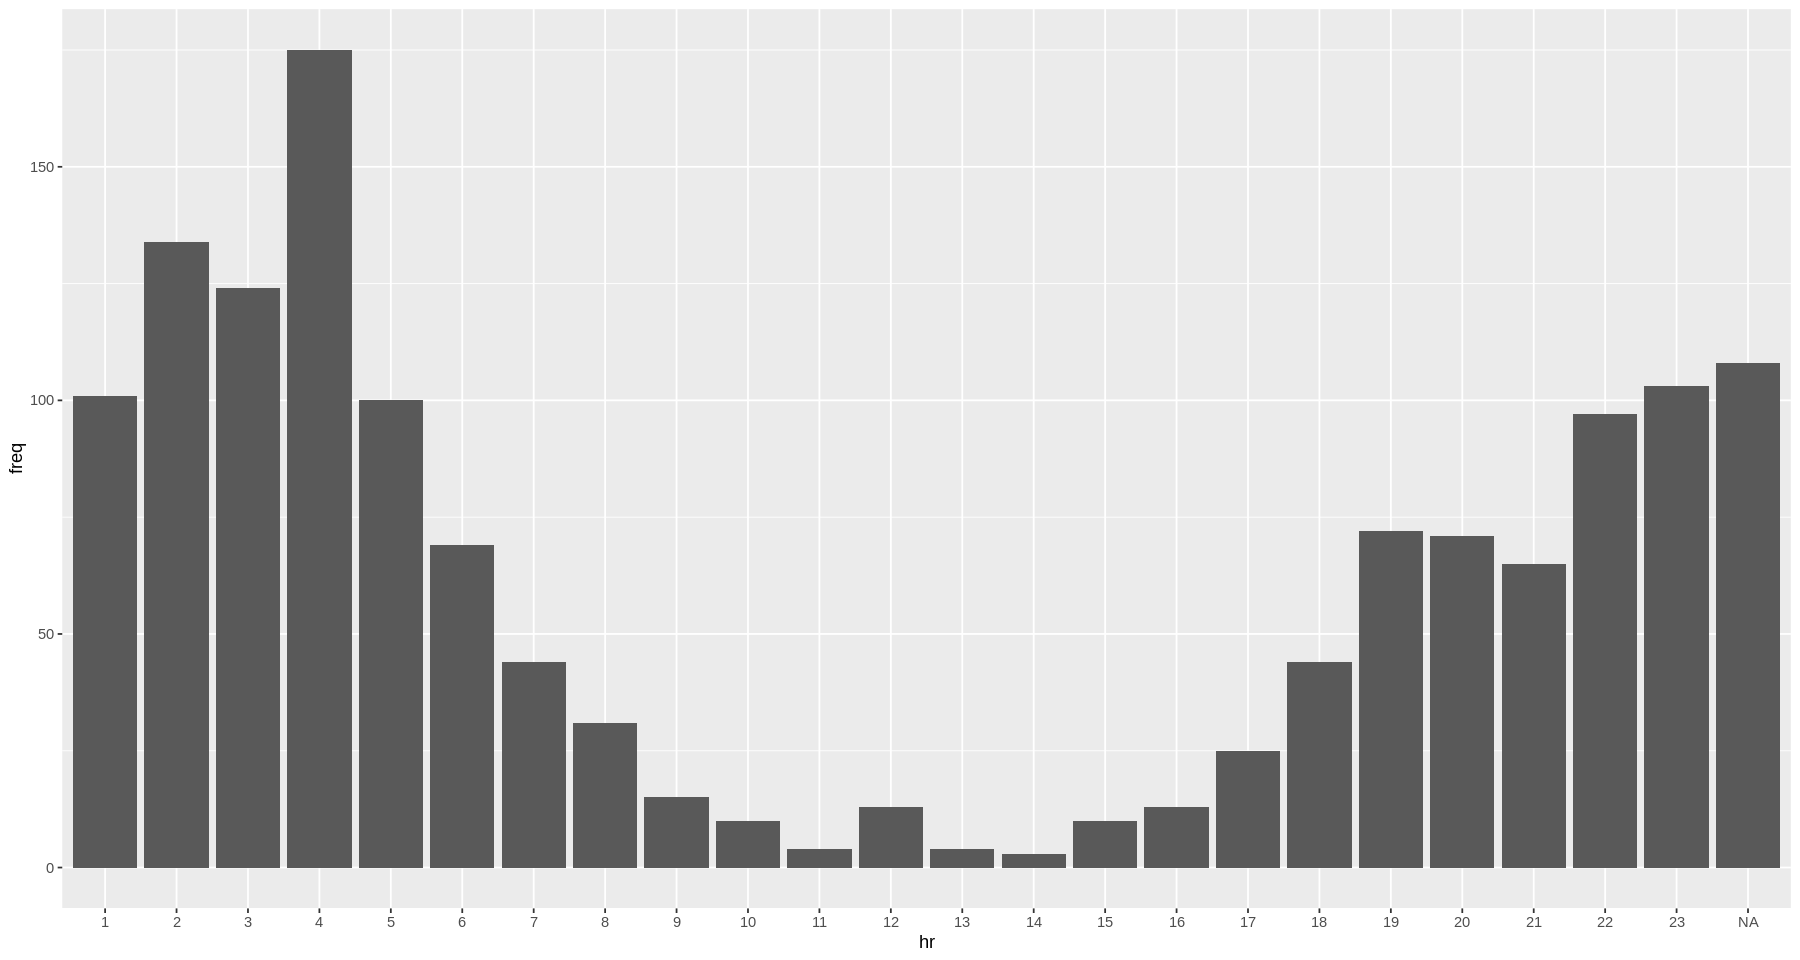

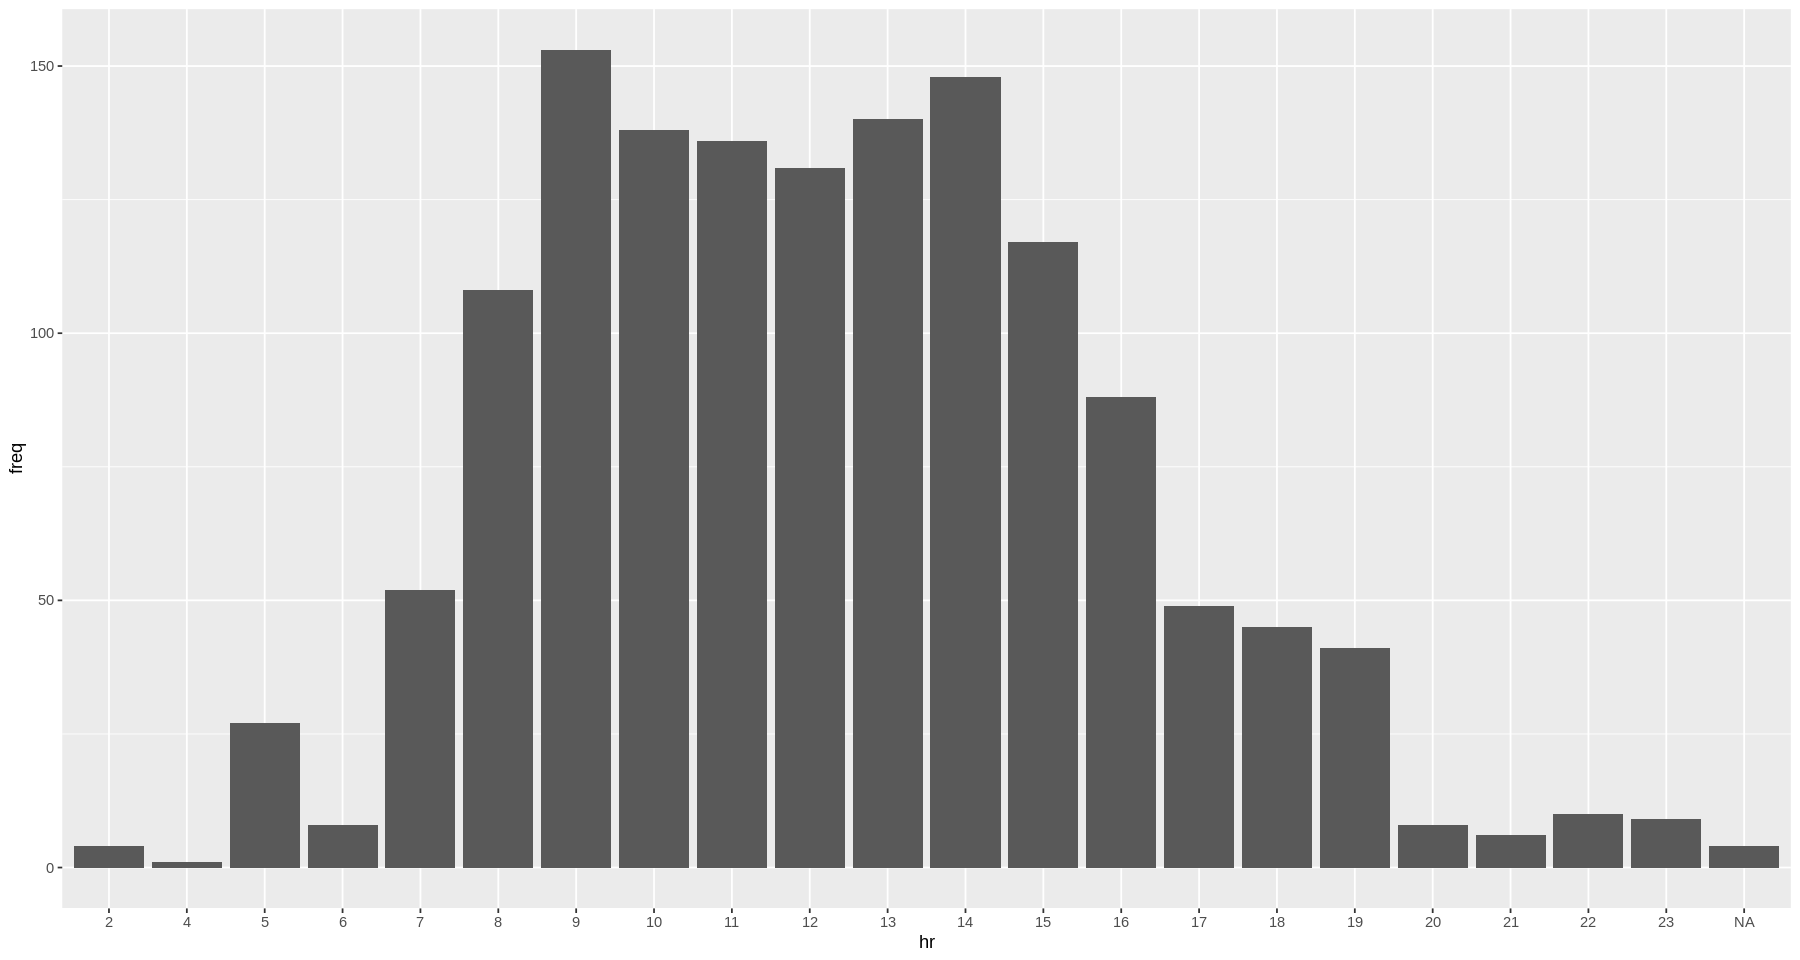

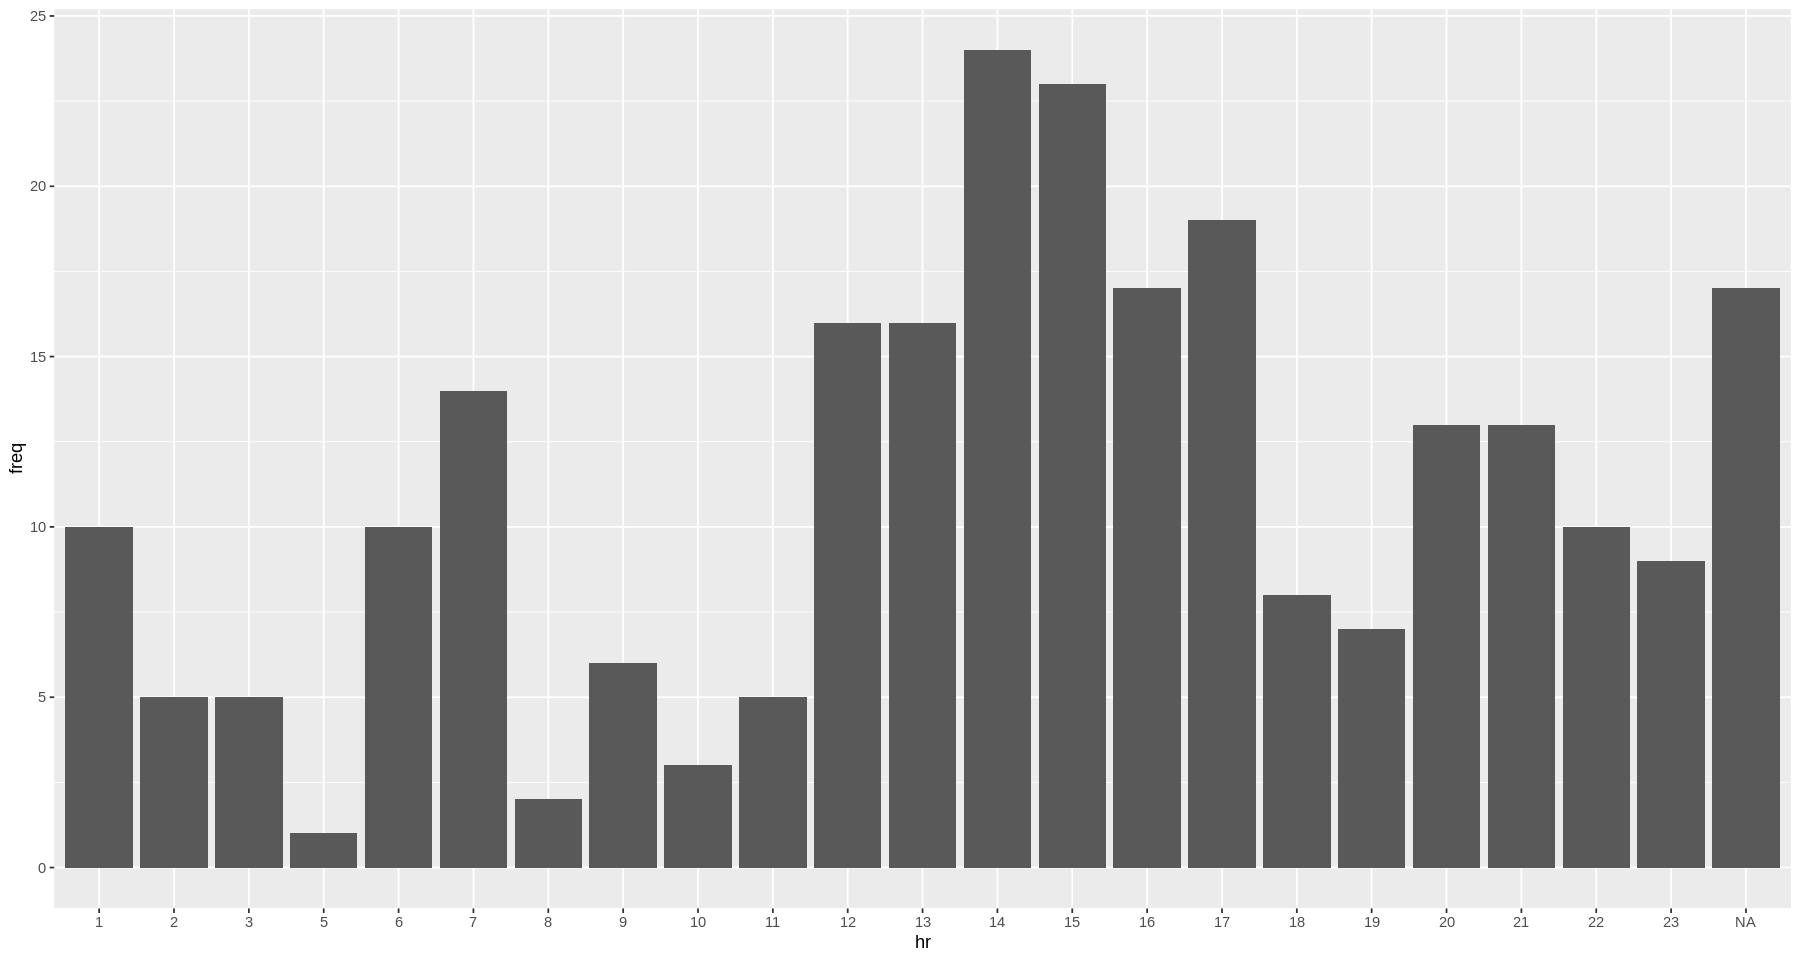

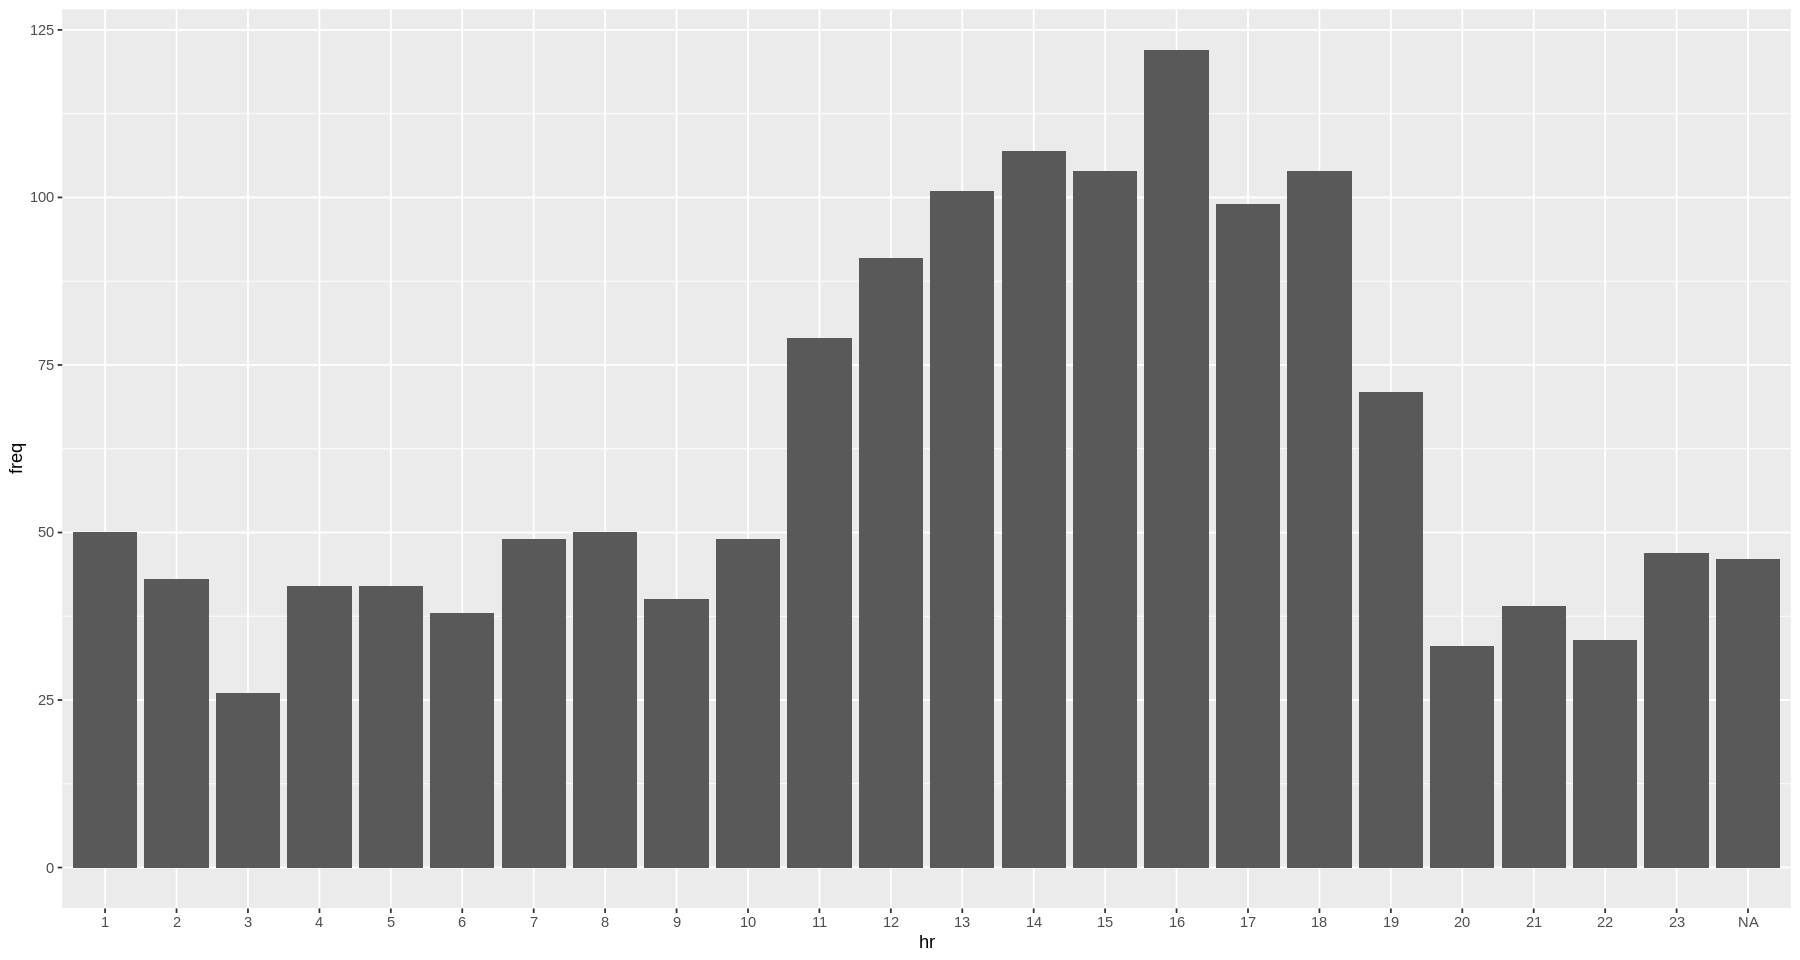

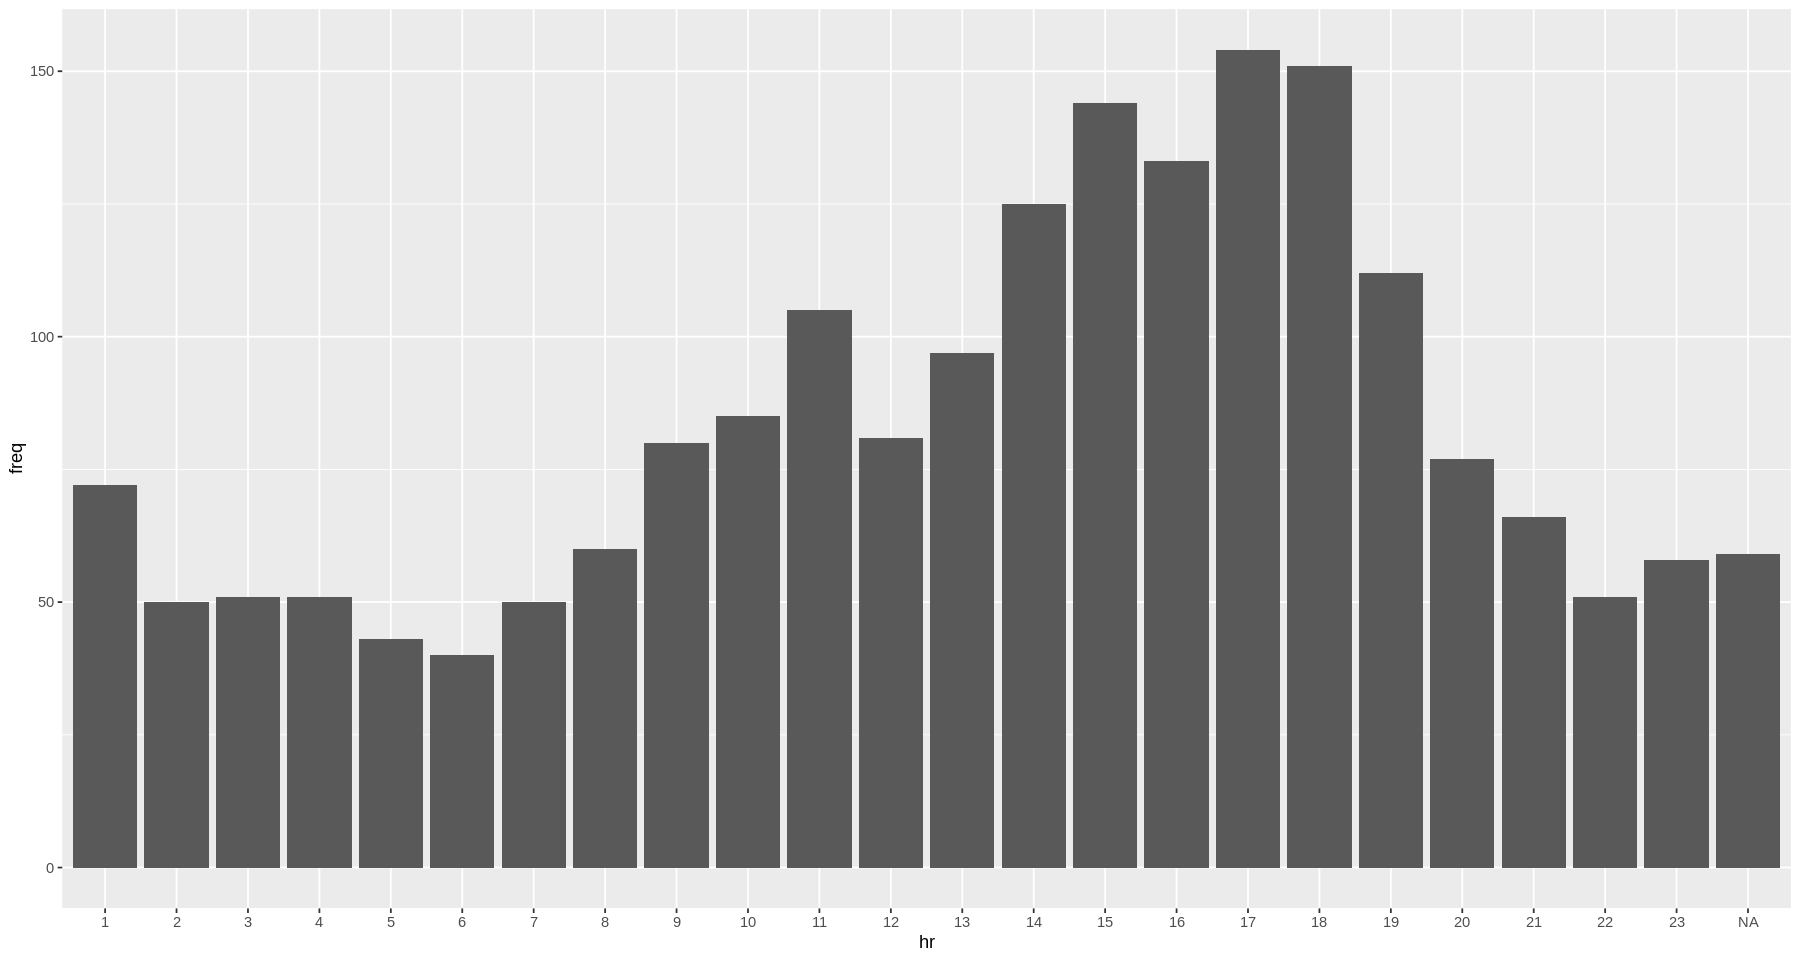

In [107]:
splitter <- function(x) {return(strsplit(x,":")[[1]][1])}
for (i in 1:NUM_CLUSTERS){
    cluster <- subset(index_data, fit.cluster==as.character(i))
    cluster$hr <- sapply(as.character(cluster$Time....character..),splitter)
    to_plot <- cluster %>% 
                count(vars = c("hr")) %>% 
                arrange(hr) %>% 
                mutate(hr=factor(hr, levels=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)))
    print(ggplot(to_plot) + geom_bar(aes(x = hr, y = freq), stat="identity"))
}


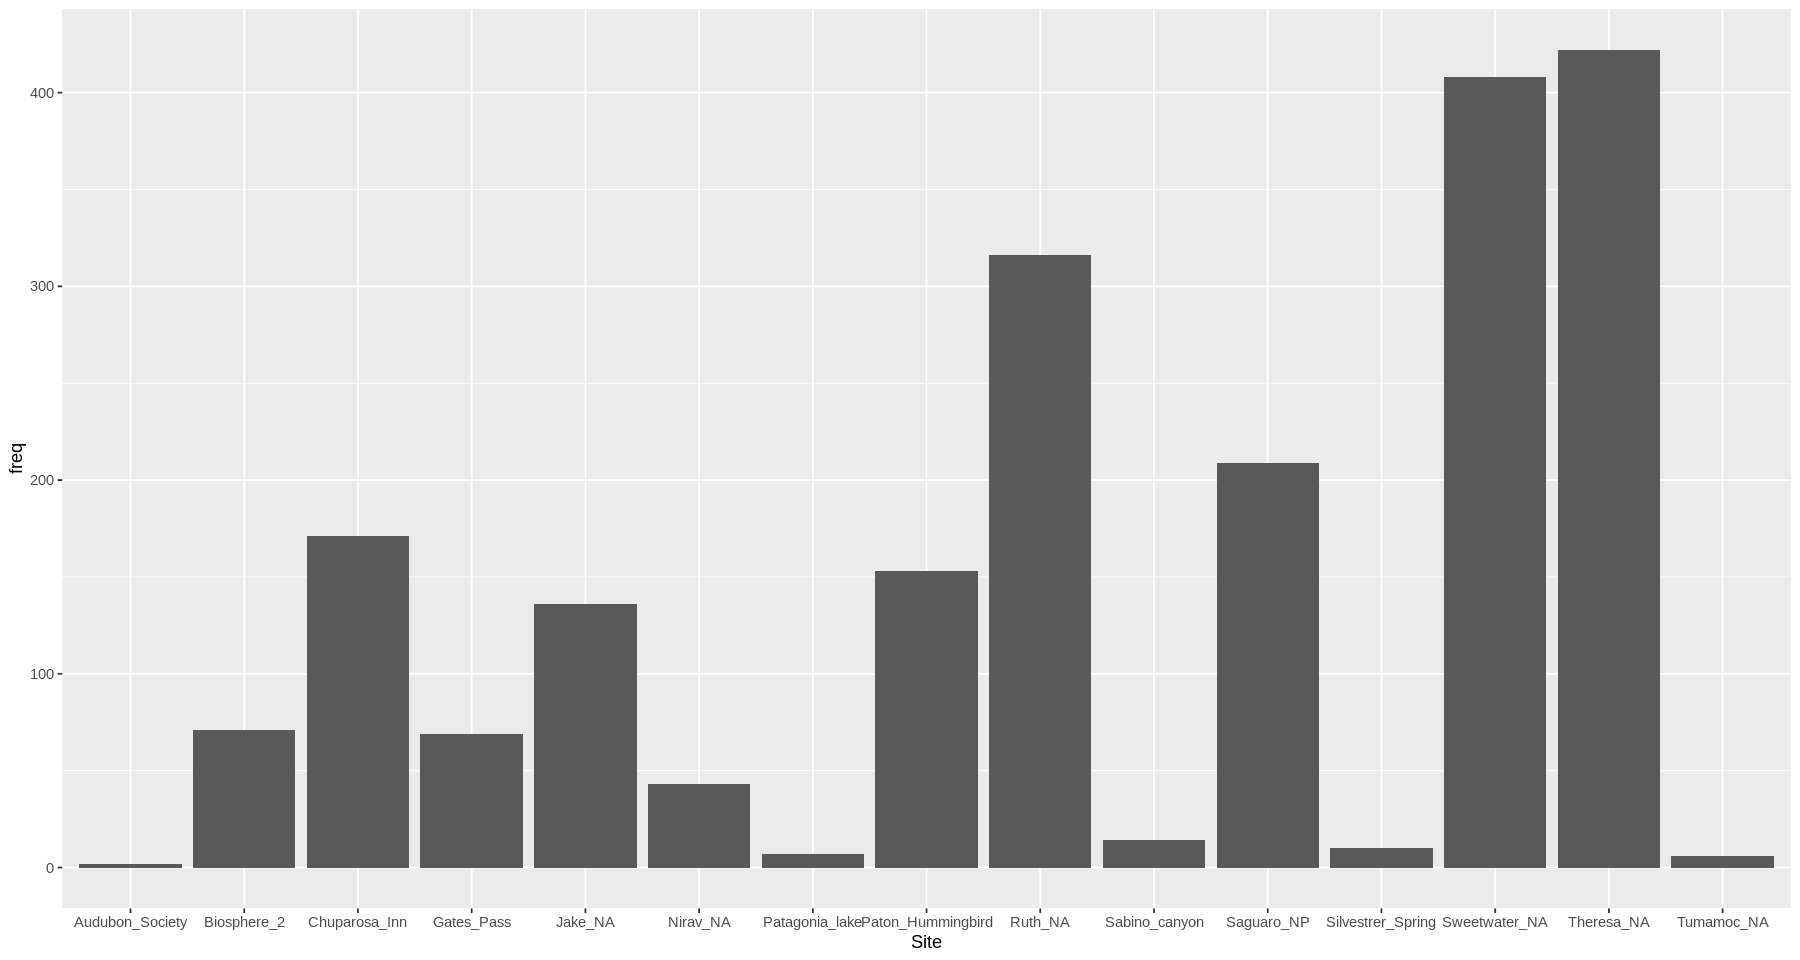

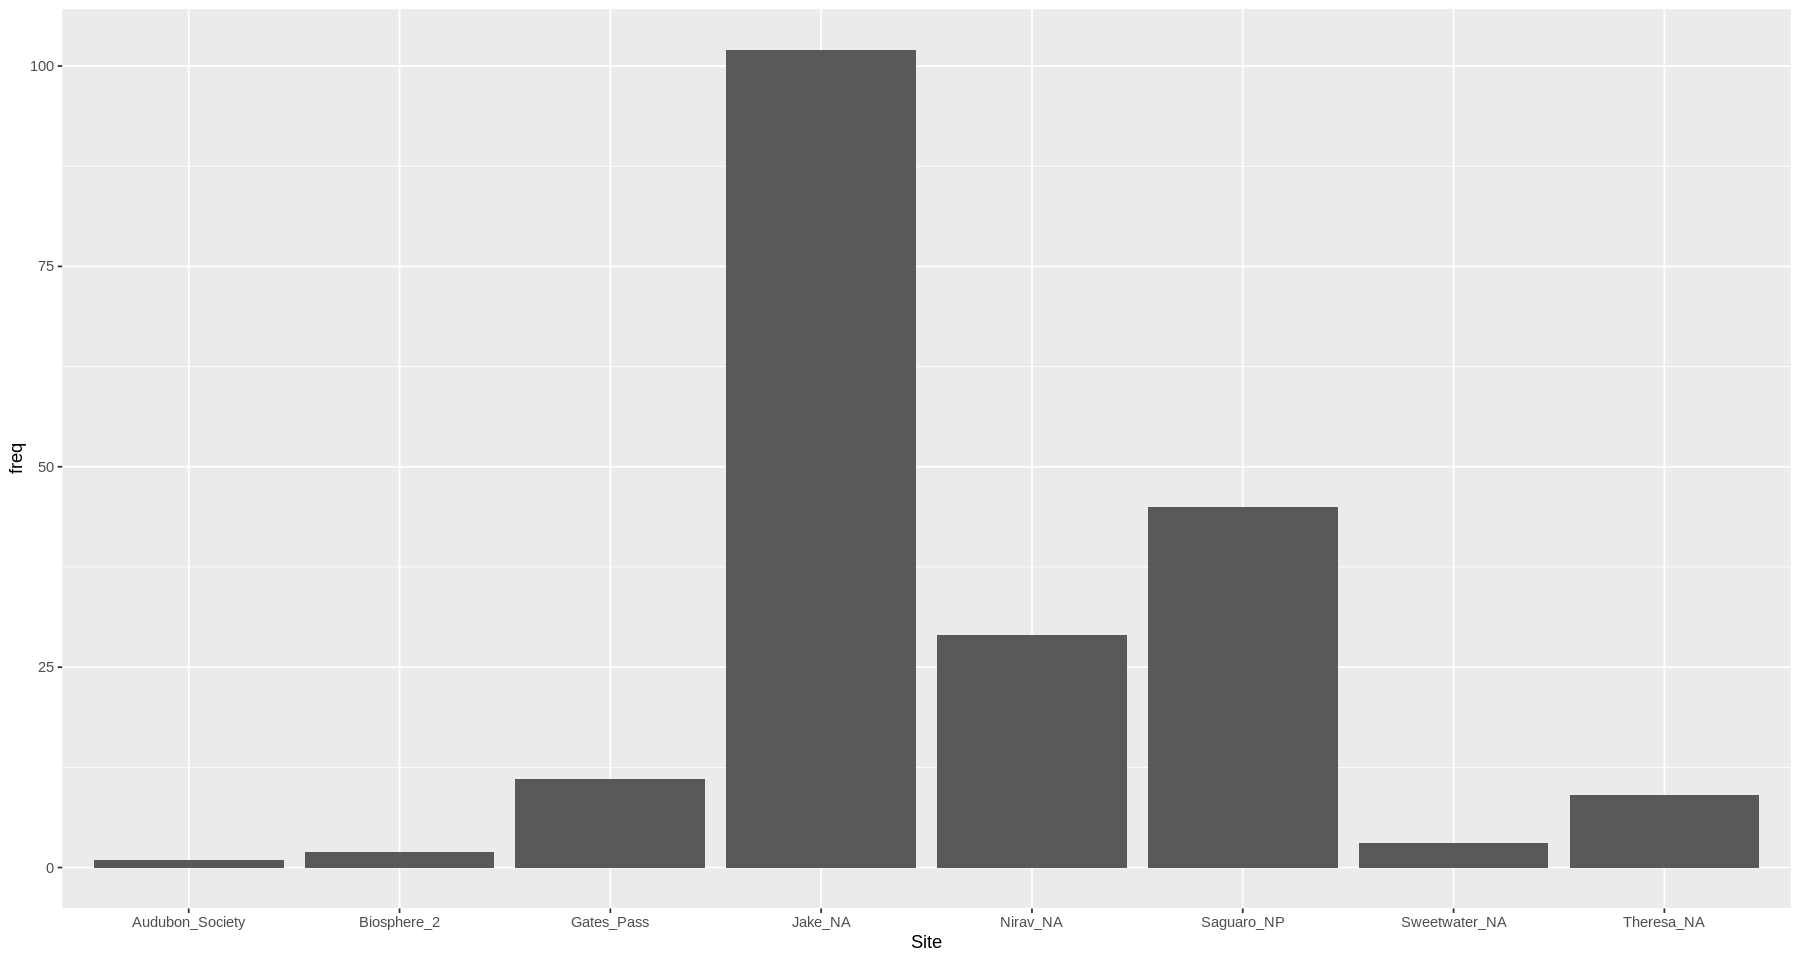

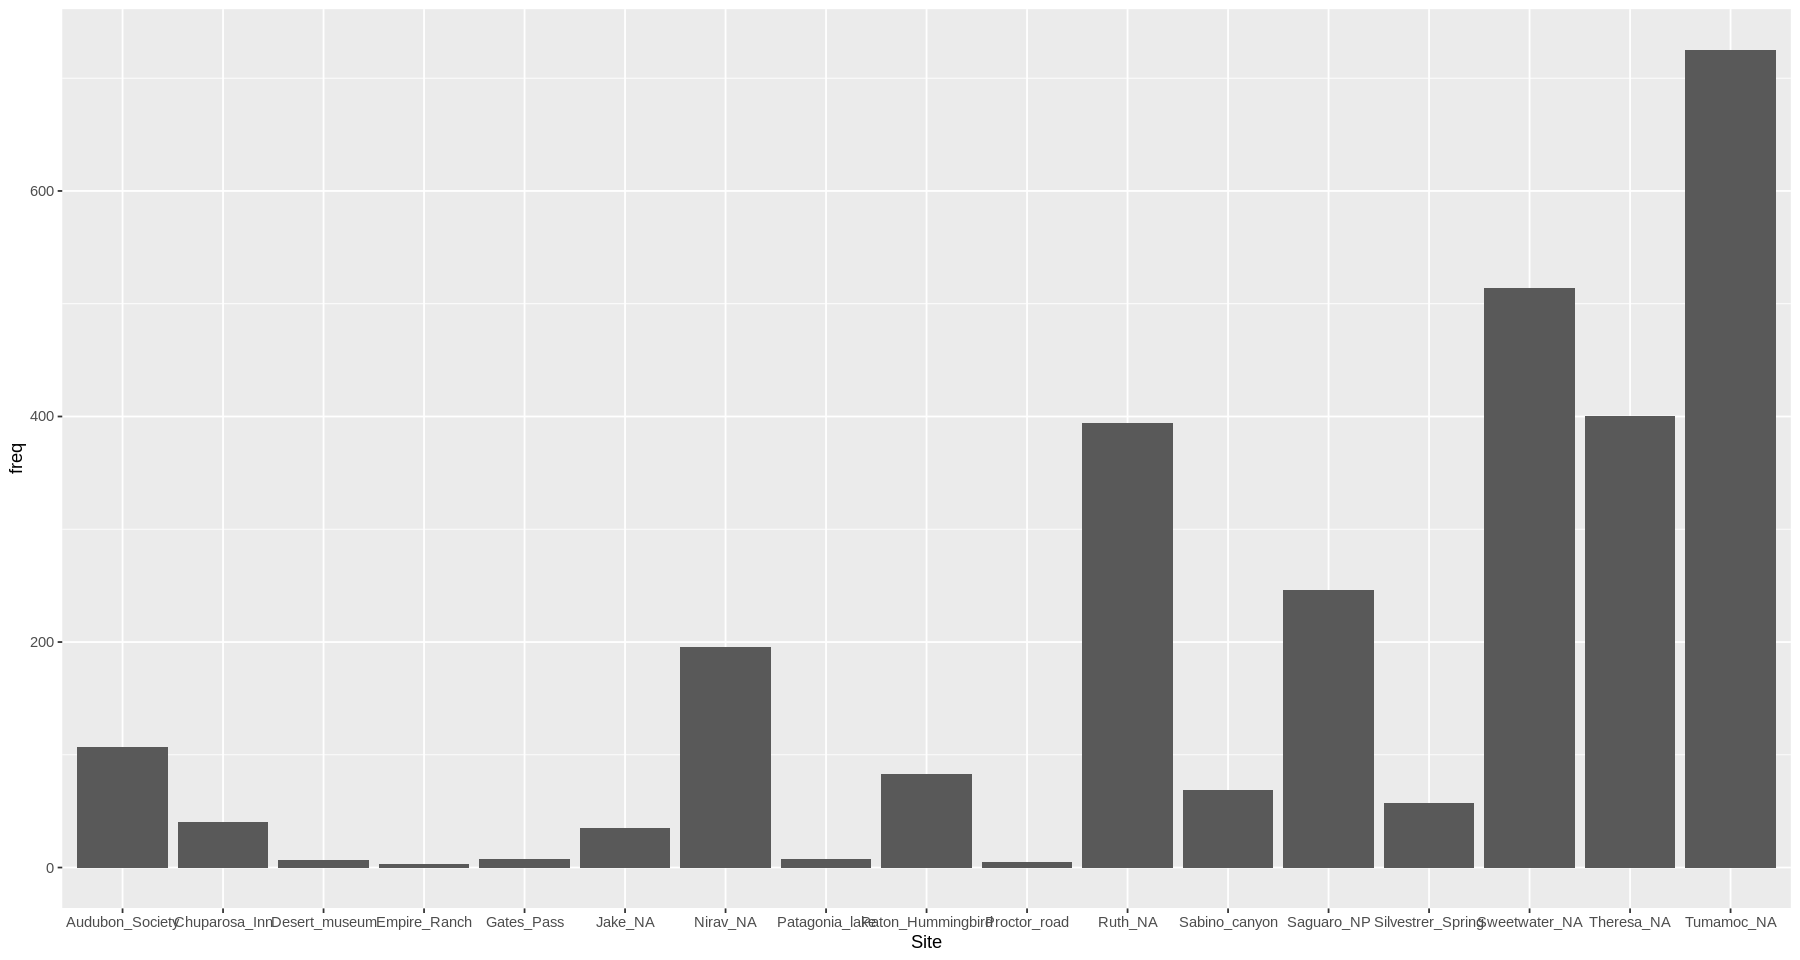

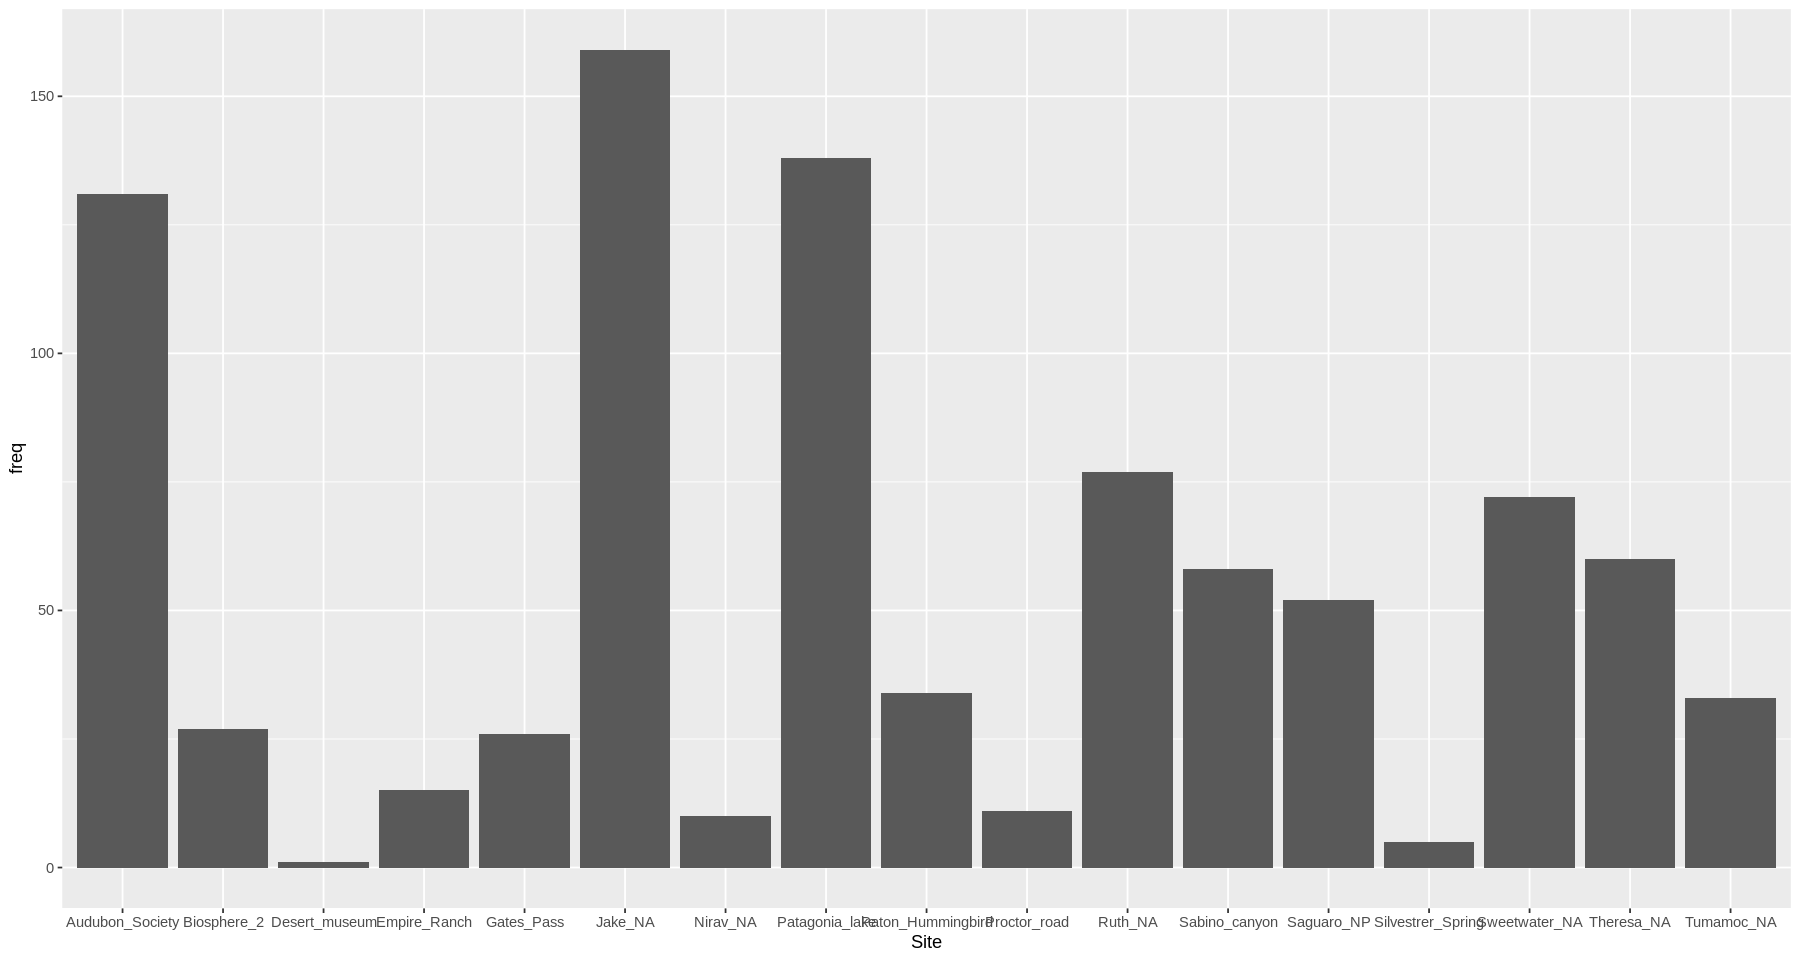

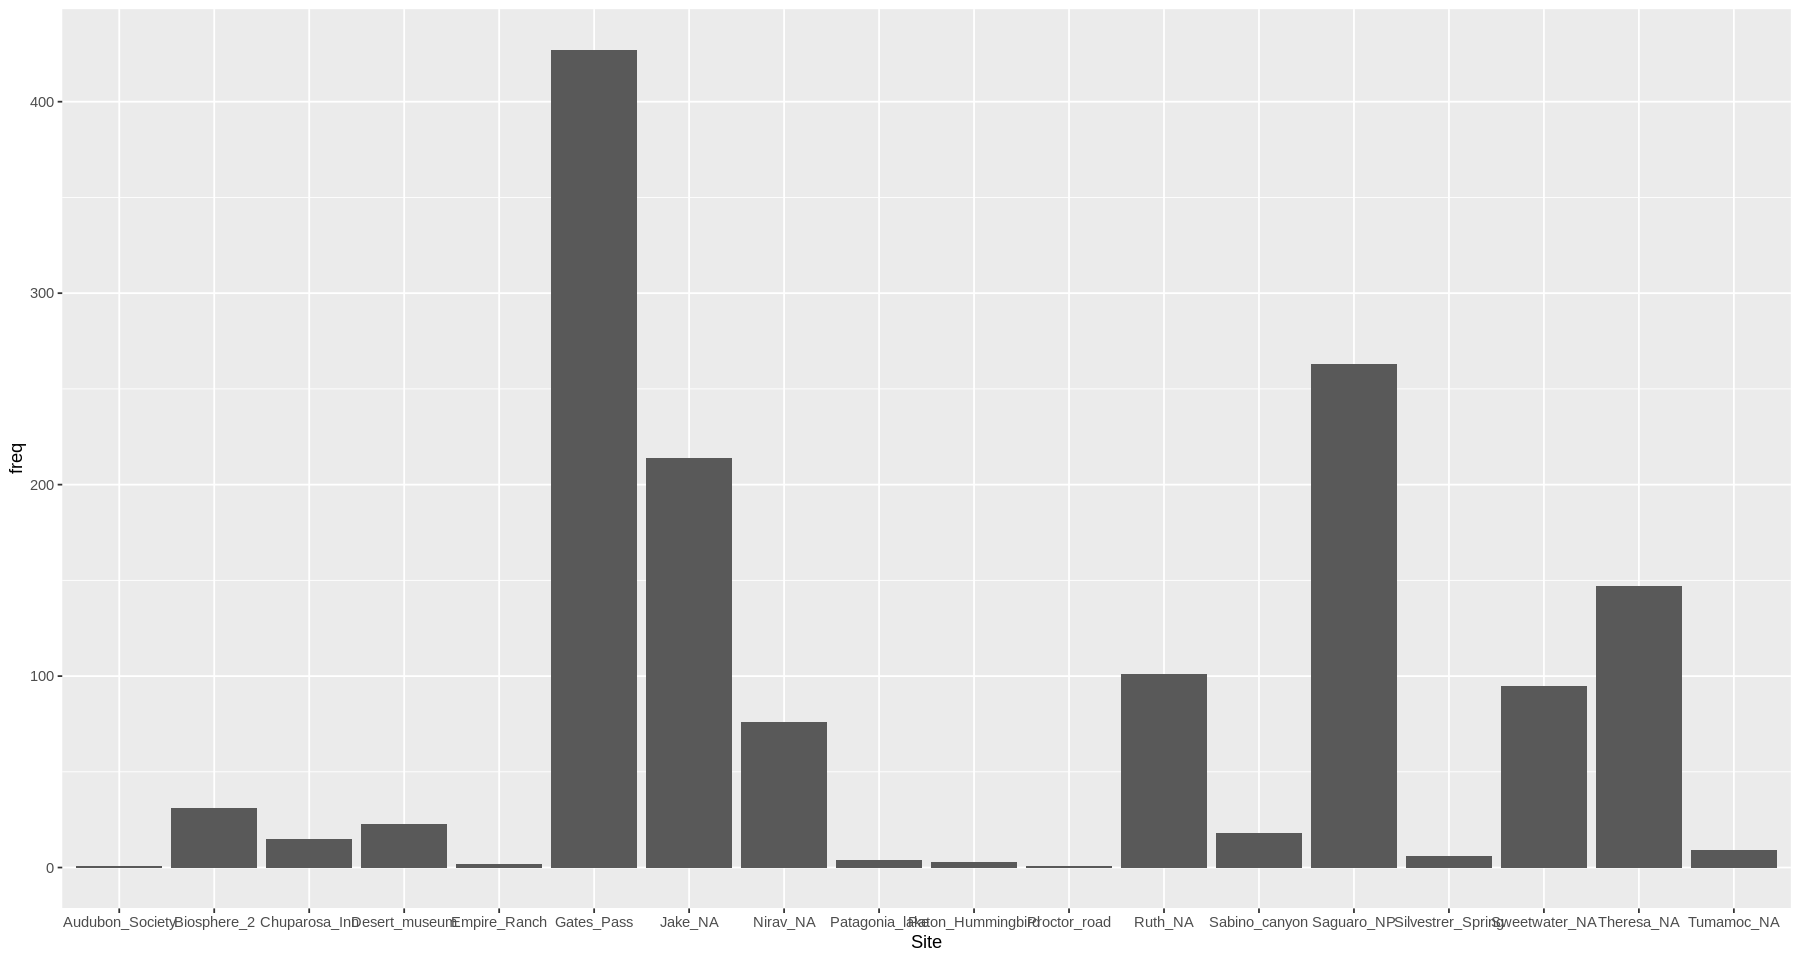

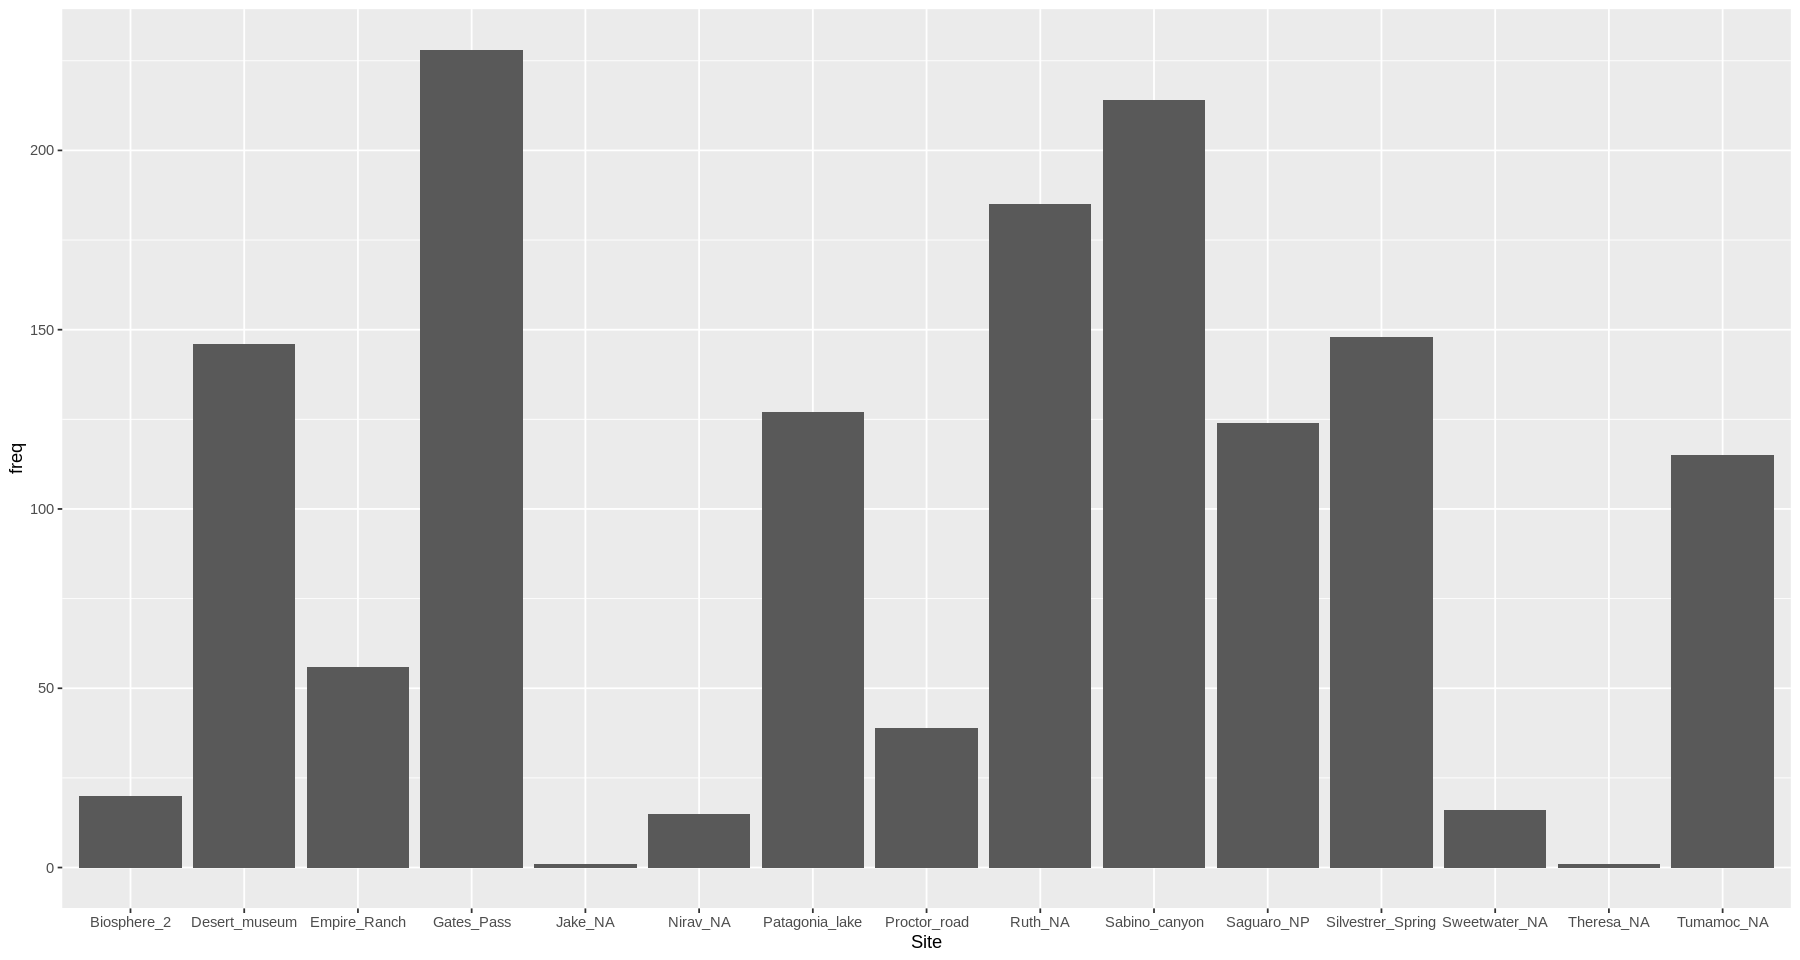

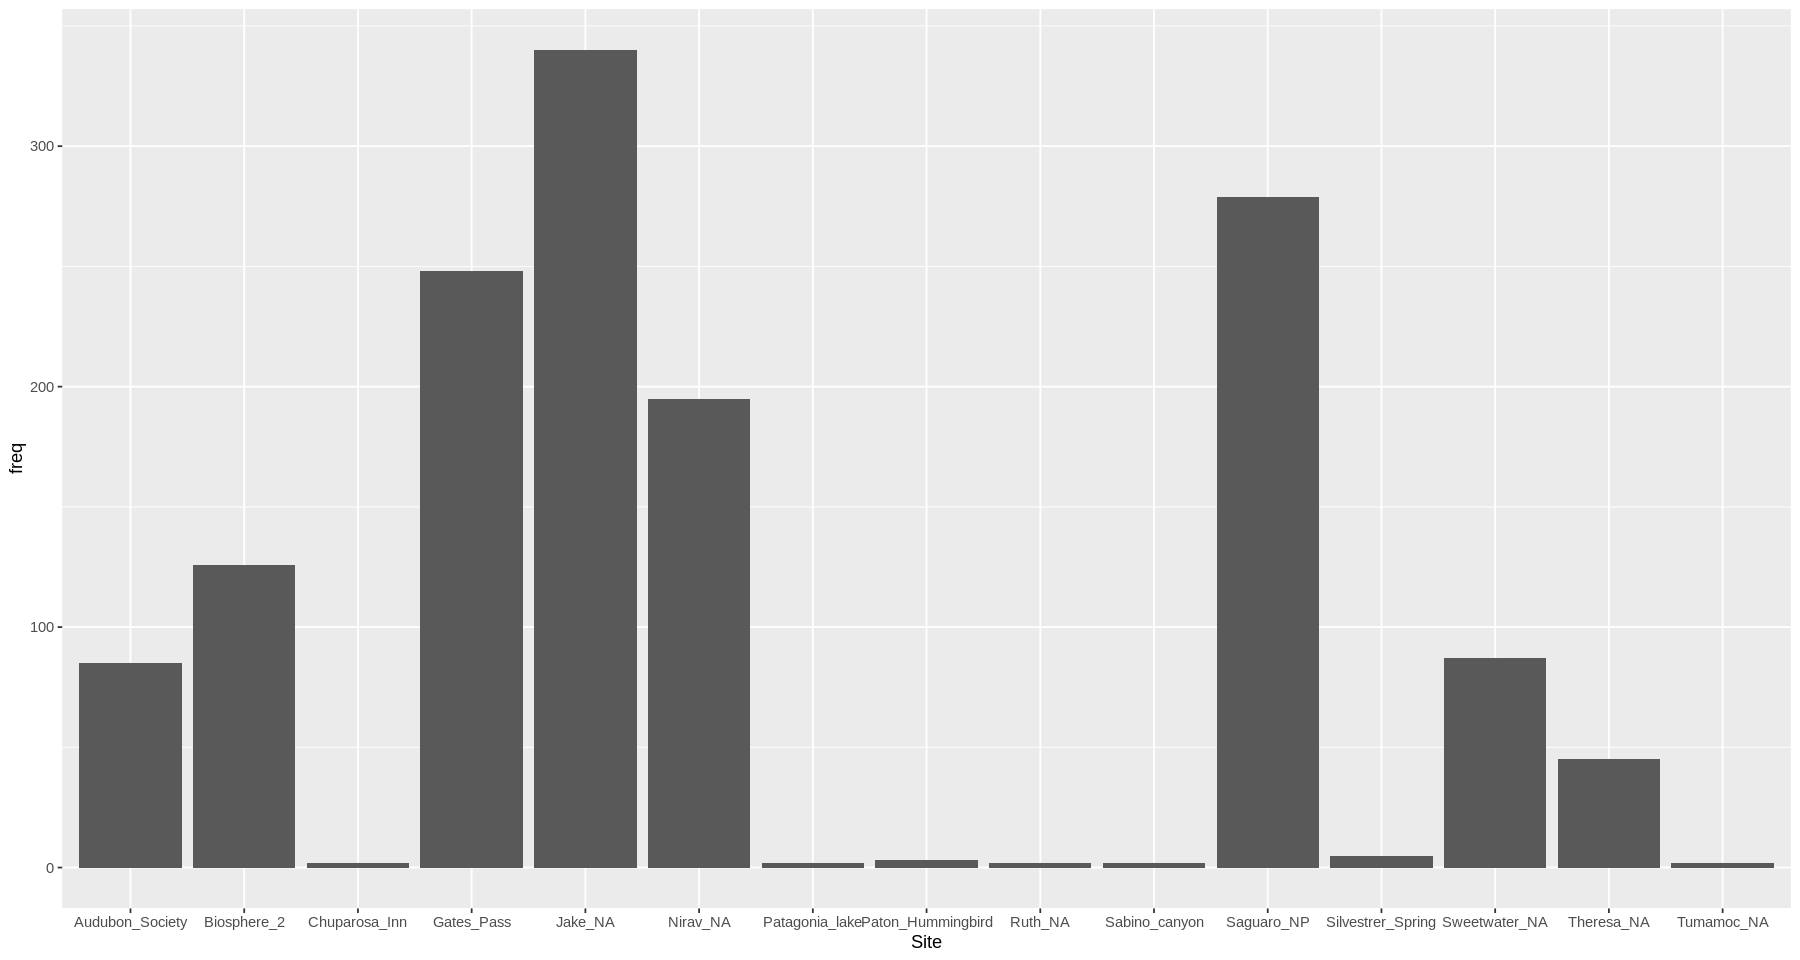

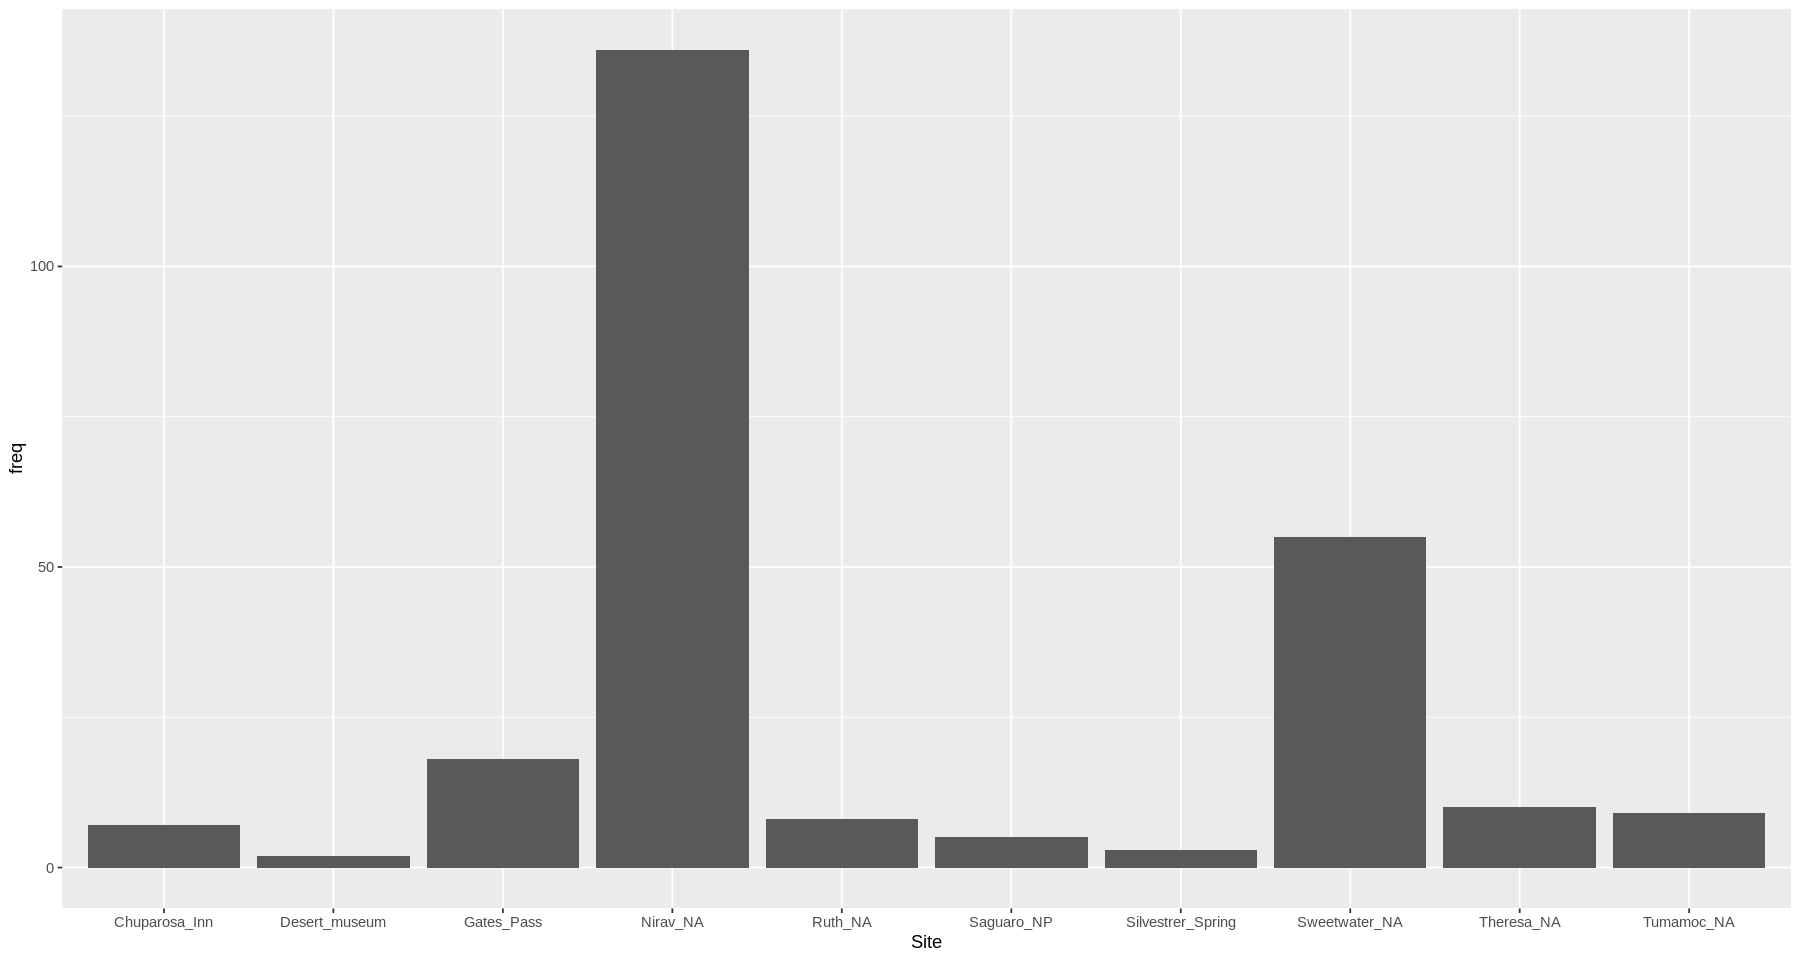

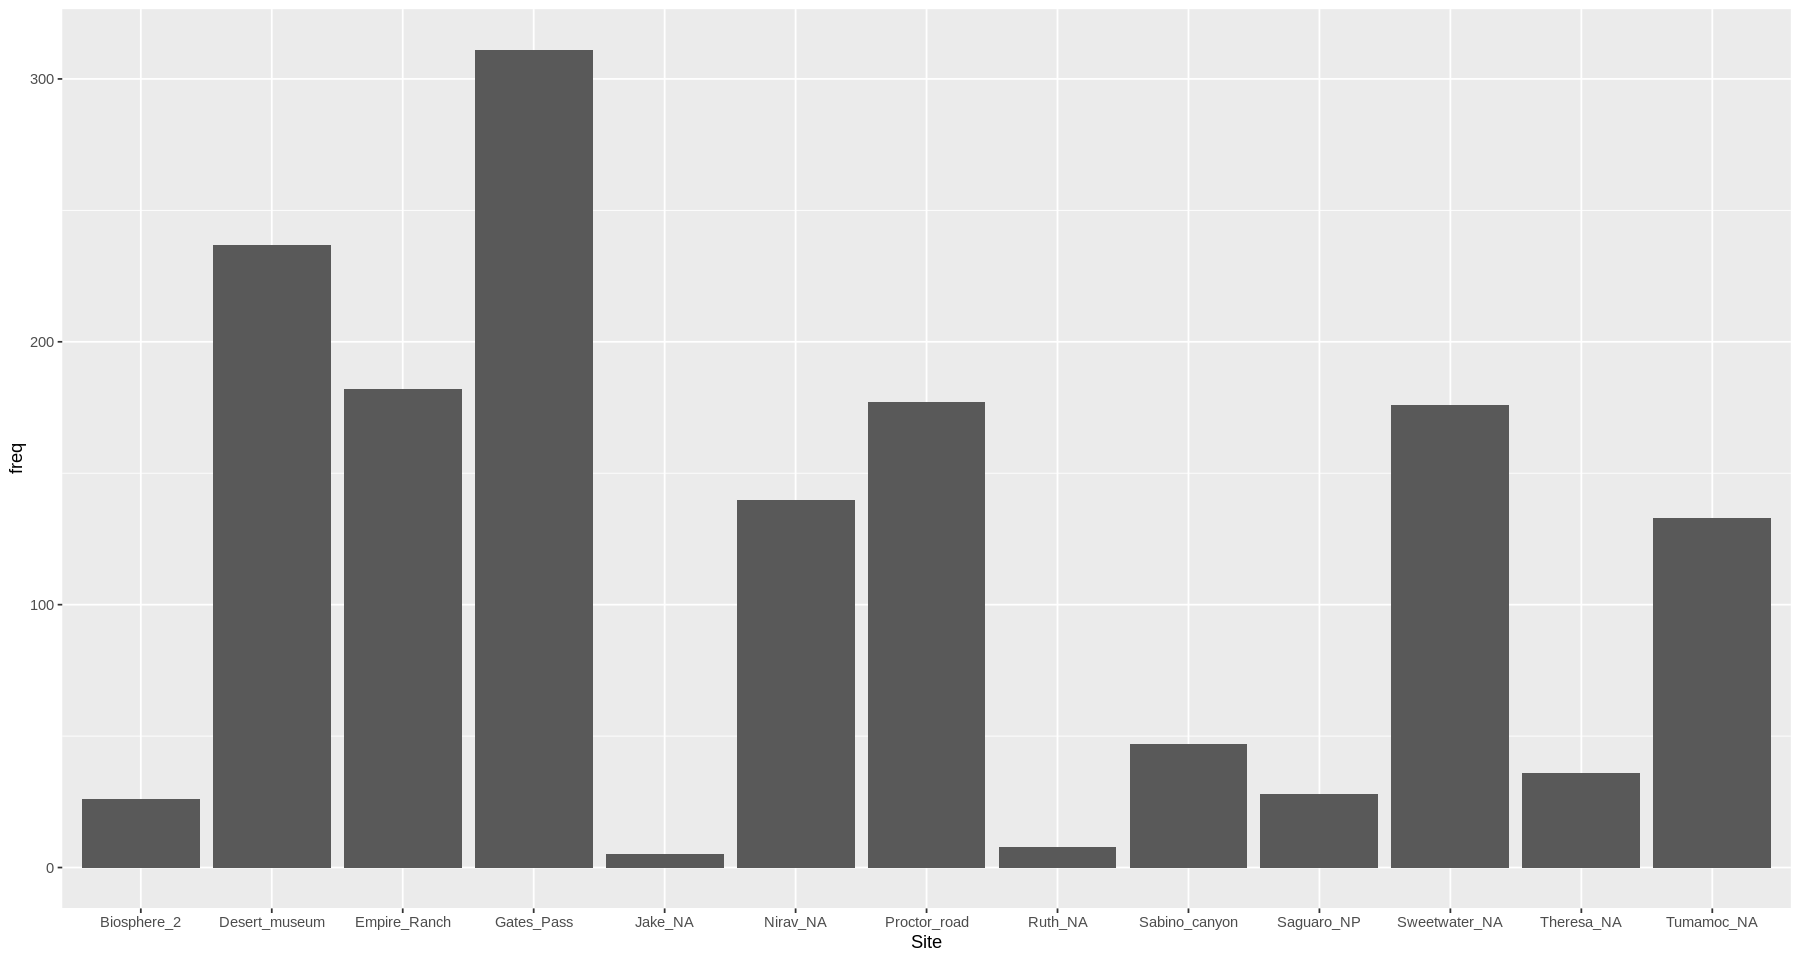

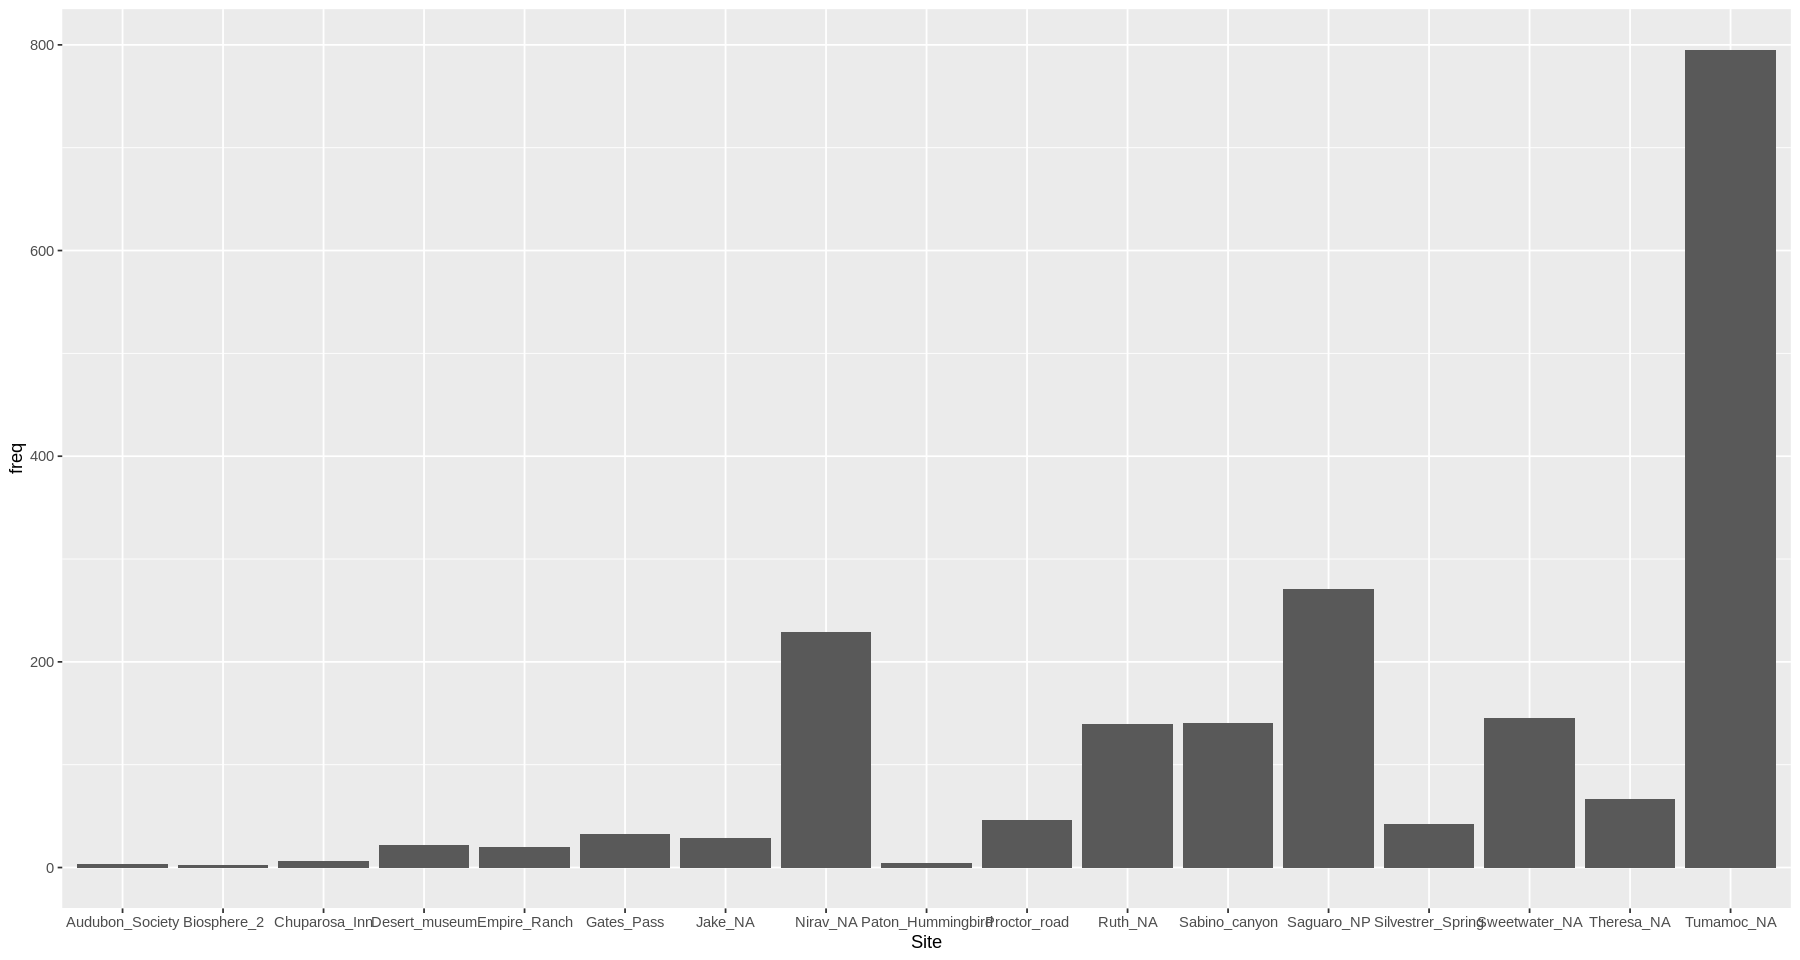

In [108]:
splitter <- function(x) {return(strsplit(x,":")[[1]][1])}
for (i in 1:NUM_CLUSTERS){
    cluster <- subset(index_data, fit.cluster==as.character(i))
    to_plot <- cluster %>% 
                count(vars = c("Site")) %>% 
                arrange(freq) 
    print(ggplot(to_plot) + geom_bar(aes(x = Site, y = freq), stat="identity"))
}

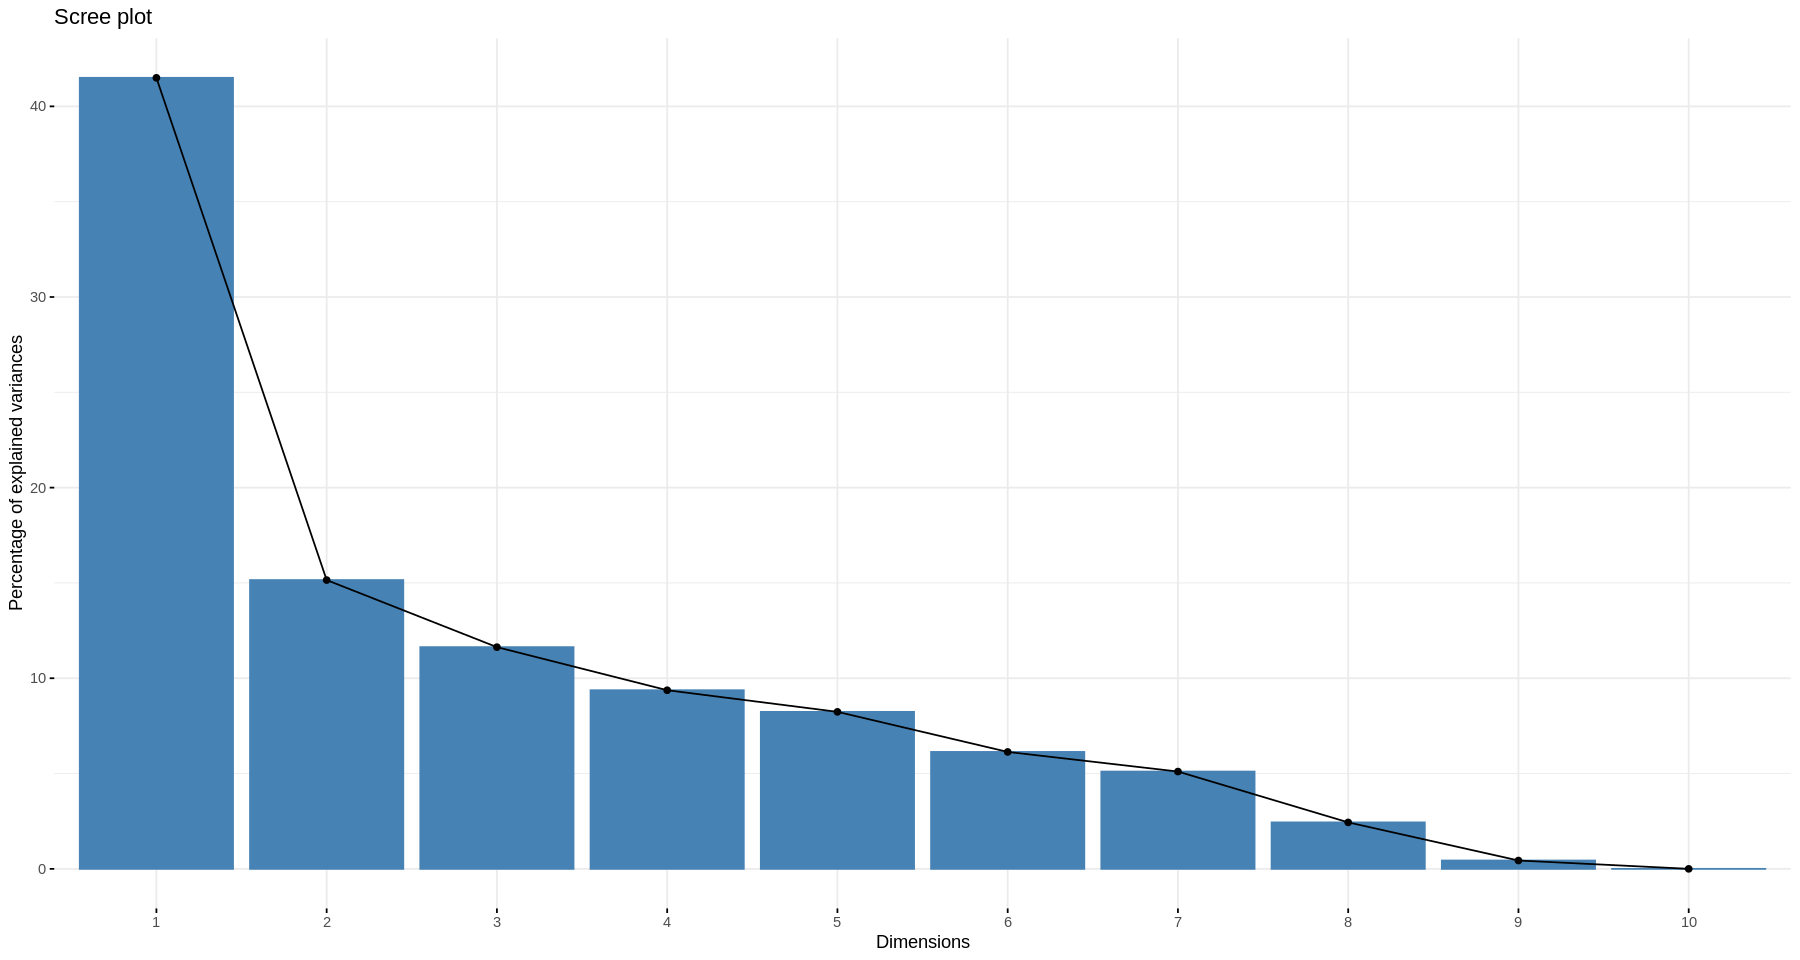

In [109]:
indices.pca <- prcomp(index_data[,4:13], scale = TRUE)
fviz_eig(indices.pca)